In [22]:
!pip -q install pandas matplotlib folium scikit-learn

import re
from struct import unpack, pack
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import normalize
import binascii
from pathlib import Path
import time
import csv

import folium

from utils import *

set_pyplot_options()

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [23]:
def show_gps(df, idx_start=1, idx_end=None, enu_format=True, annotate=False):
    
    dx, dy, _ = geodetic_to_enu(lat0+0.0001,lon0+0.0001,0, lat0, lon0, h0)
    background_ratio = dy/dx

    time = df[['time']][idx_start:idx_end].to_numpy()
    lat  = df[['latitude']][idx_start:idx_end].to_numpy()
    lon  = df[['longitude']][idx_start:idx_end].to_numpy()
    enu_x = df[['enu_x']][idx_start:idx_end].to_numpy()
    enu_y = df[['enu_y']][idx_start:idx_end].to_numpy()

    pos_range = [129.3186, 129.3202, 36.0124, 36.0140] # POSTECH Field
    
    if(enu_format):
        lat = enu_y
        lon = enu_x
    else:
        #plt.axis(pos_range)
        img = plt.imread("background2.png")
        plt.imshow(img, extent=pos_range)

    if(annotate):
        for idx, xy in enumerate(zip(lon,lat)):
            if(idx % 10 == 0):
                plt.annotate('{}'.format(int(df.index[idx])), xy=xy, textcoords='data', fontsize=50)
        #       plt.annotate('{},{:.3f},{:.3f}'.format(idx, xy[0], xy[1]), xy=xy, textcoords='data')
    hfont = {'fontname':'Serif'}
    plt.plot(lon,lat,'ko', markersize=15, label='GPS Path')
    #plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
   #plt.gca().get_yaxis().get_major_formatter().set_useOffset(False)
    plt.axes().set_aspect(1)
    plt.grid(b=True)
    plt.xlabel('X (m)', fontsize=80, labelpad=30, **hfont)
    plt.ylabel('Y (m)', fontsize=80, labelpad=30, **hfont)
    plt.xticks(fontsize =80)
    plt.yticks(fontsize =80)
    plt.legend(prop={'size': 80}, loc=2)
    plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


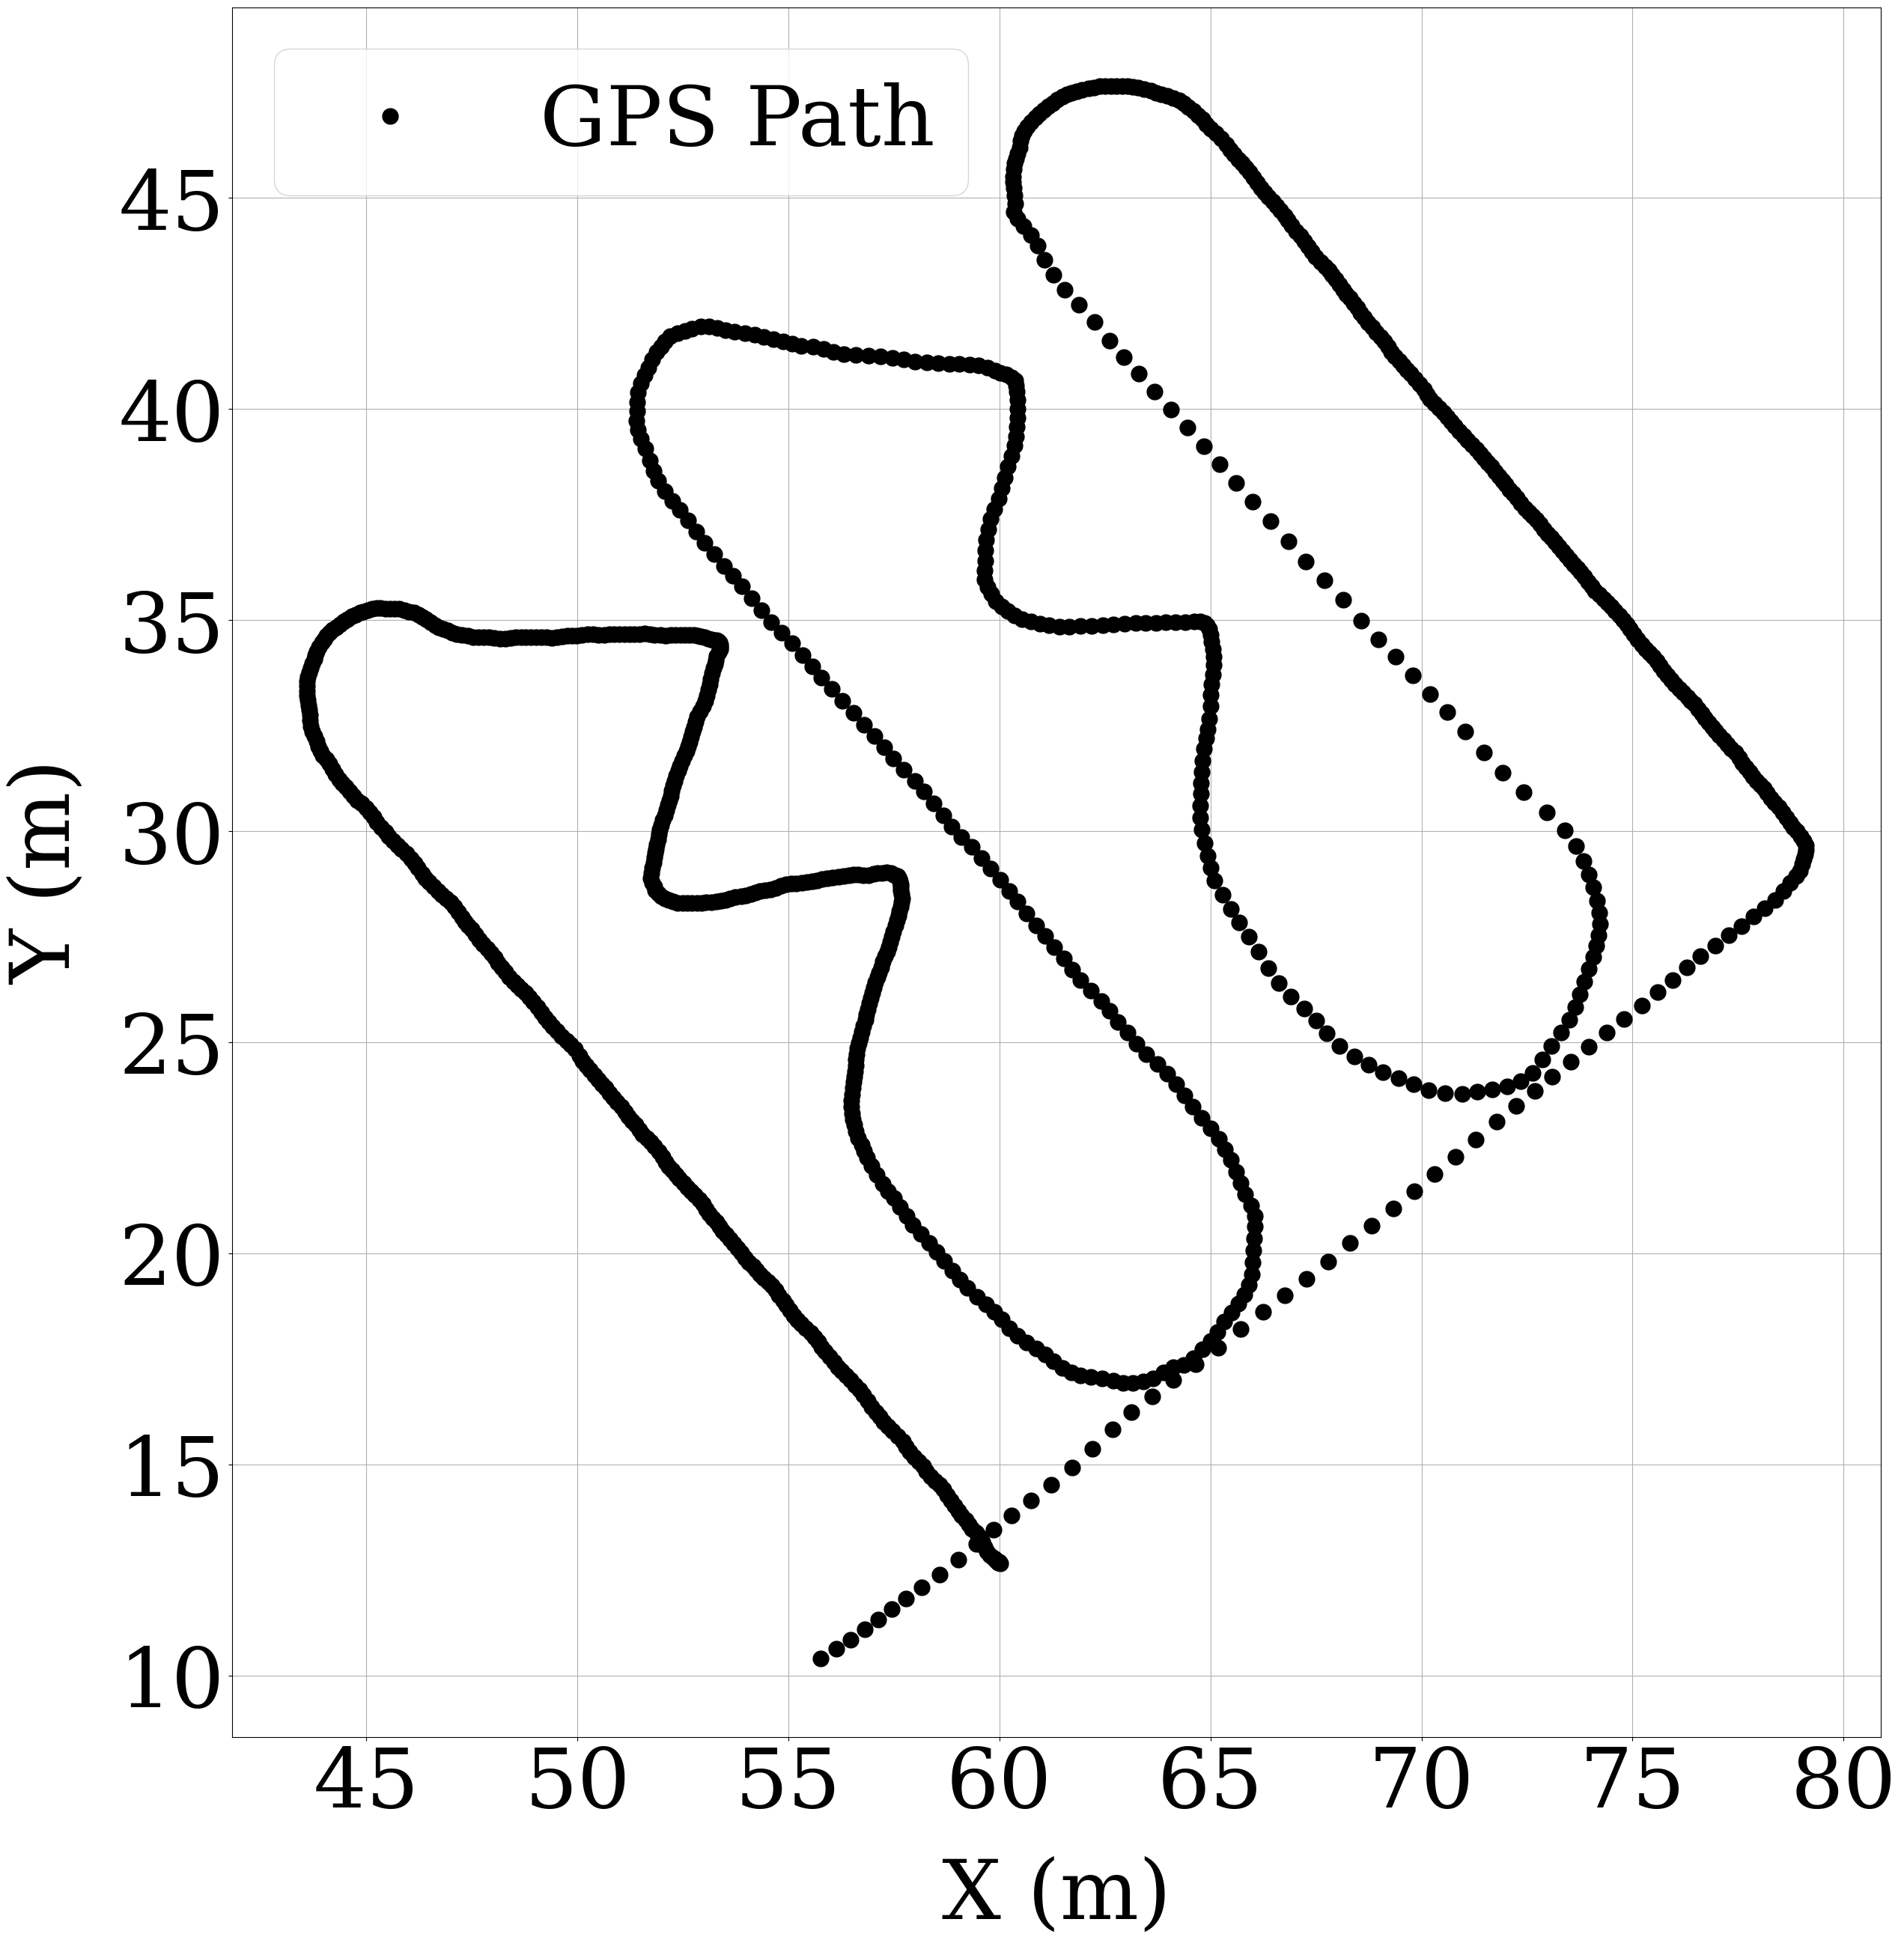

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


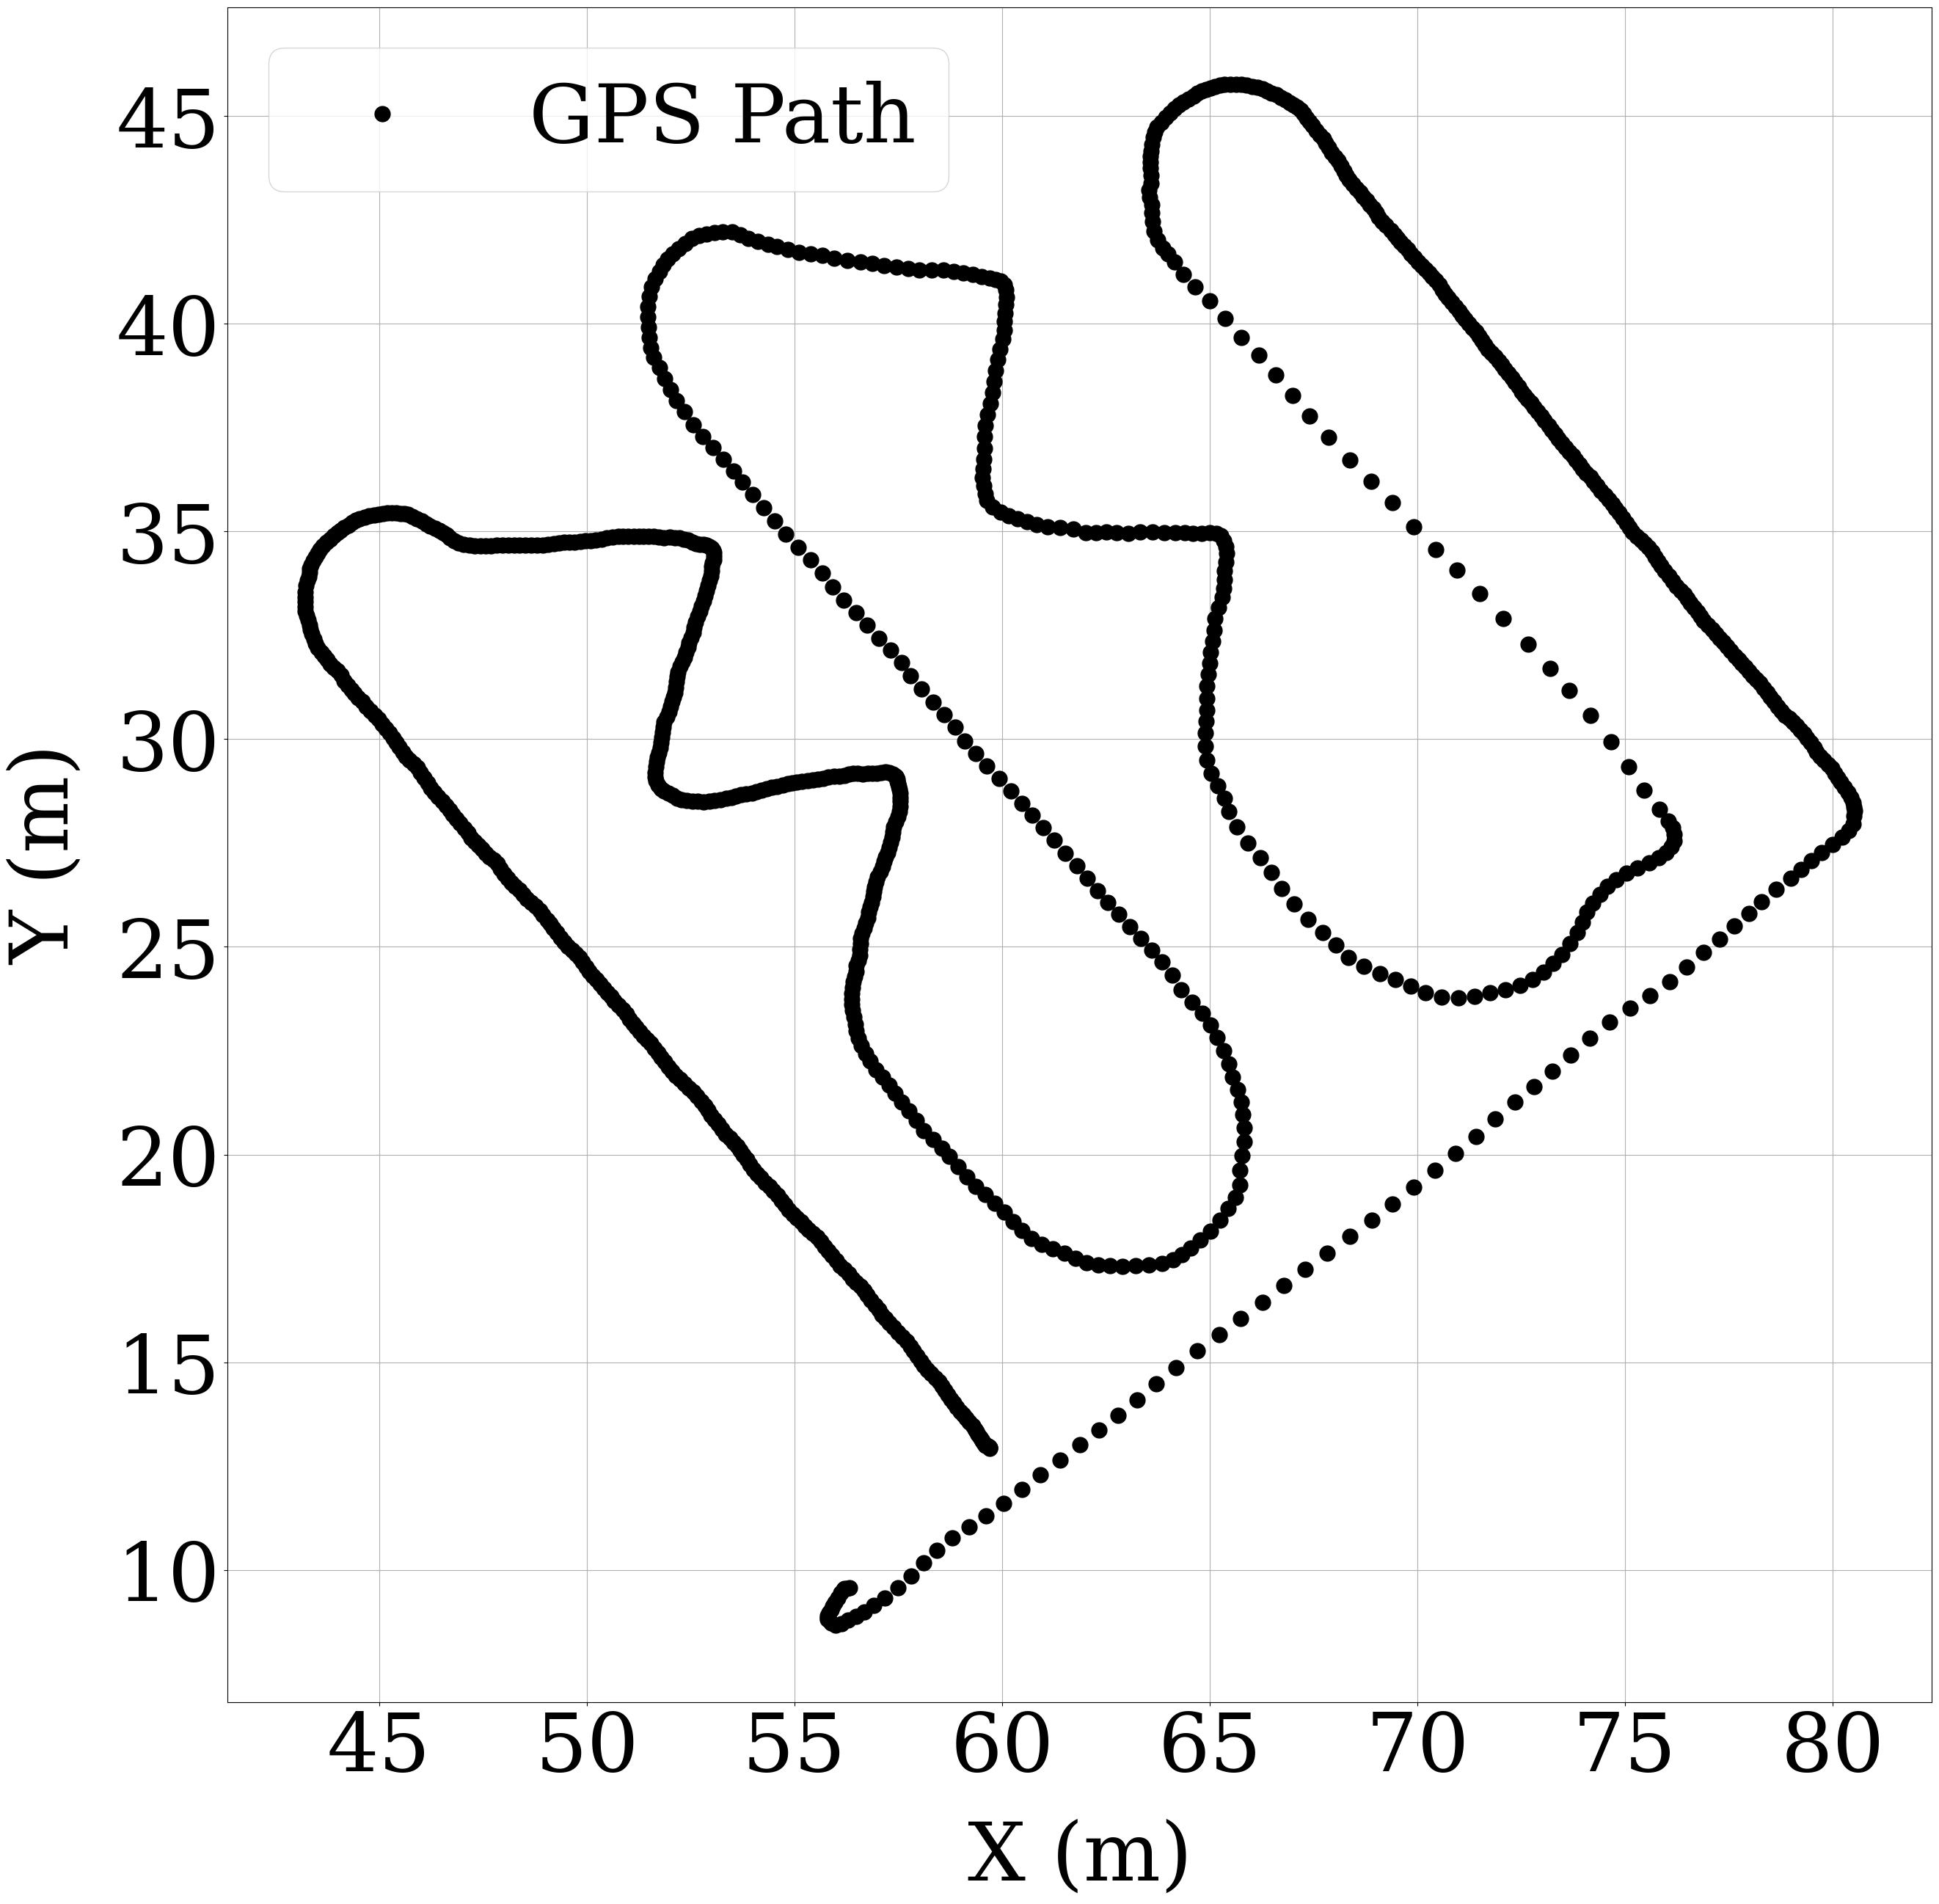

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


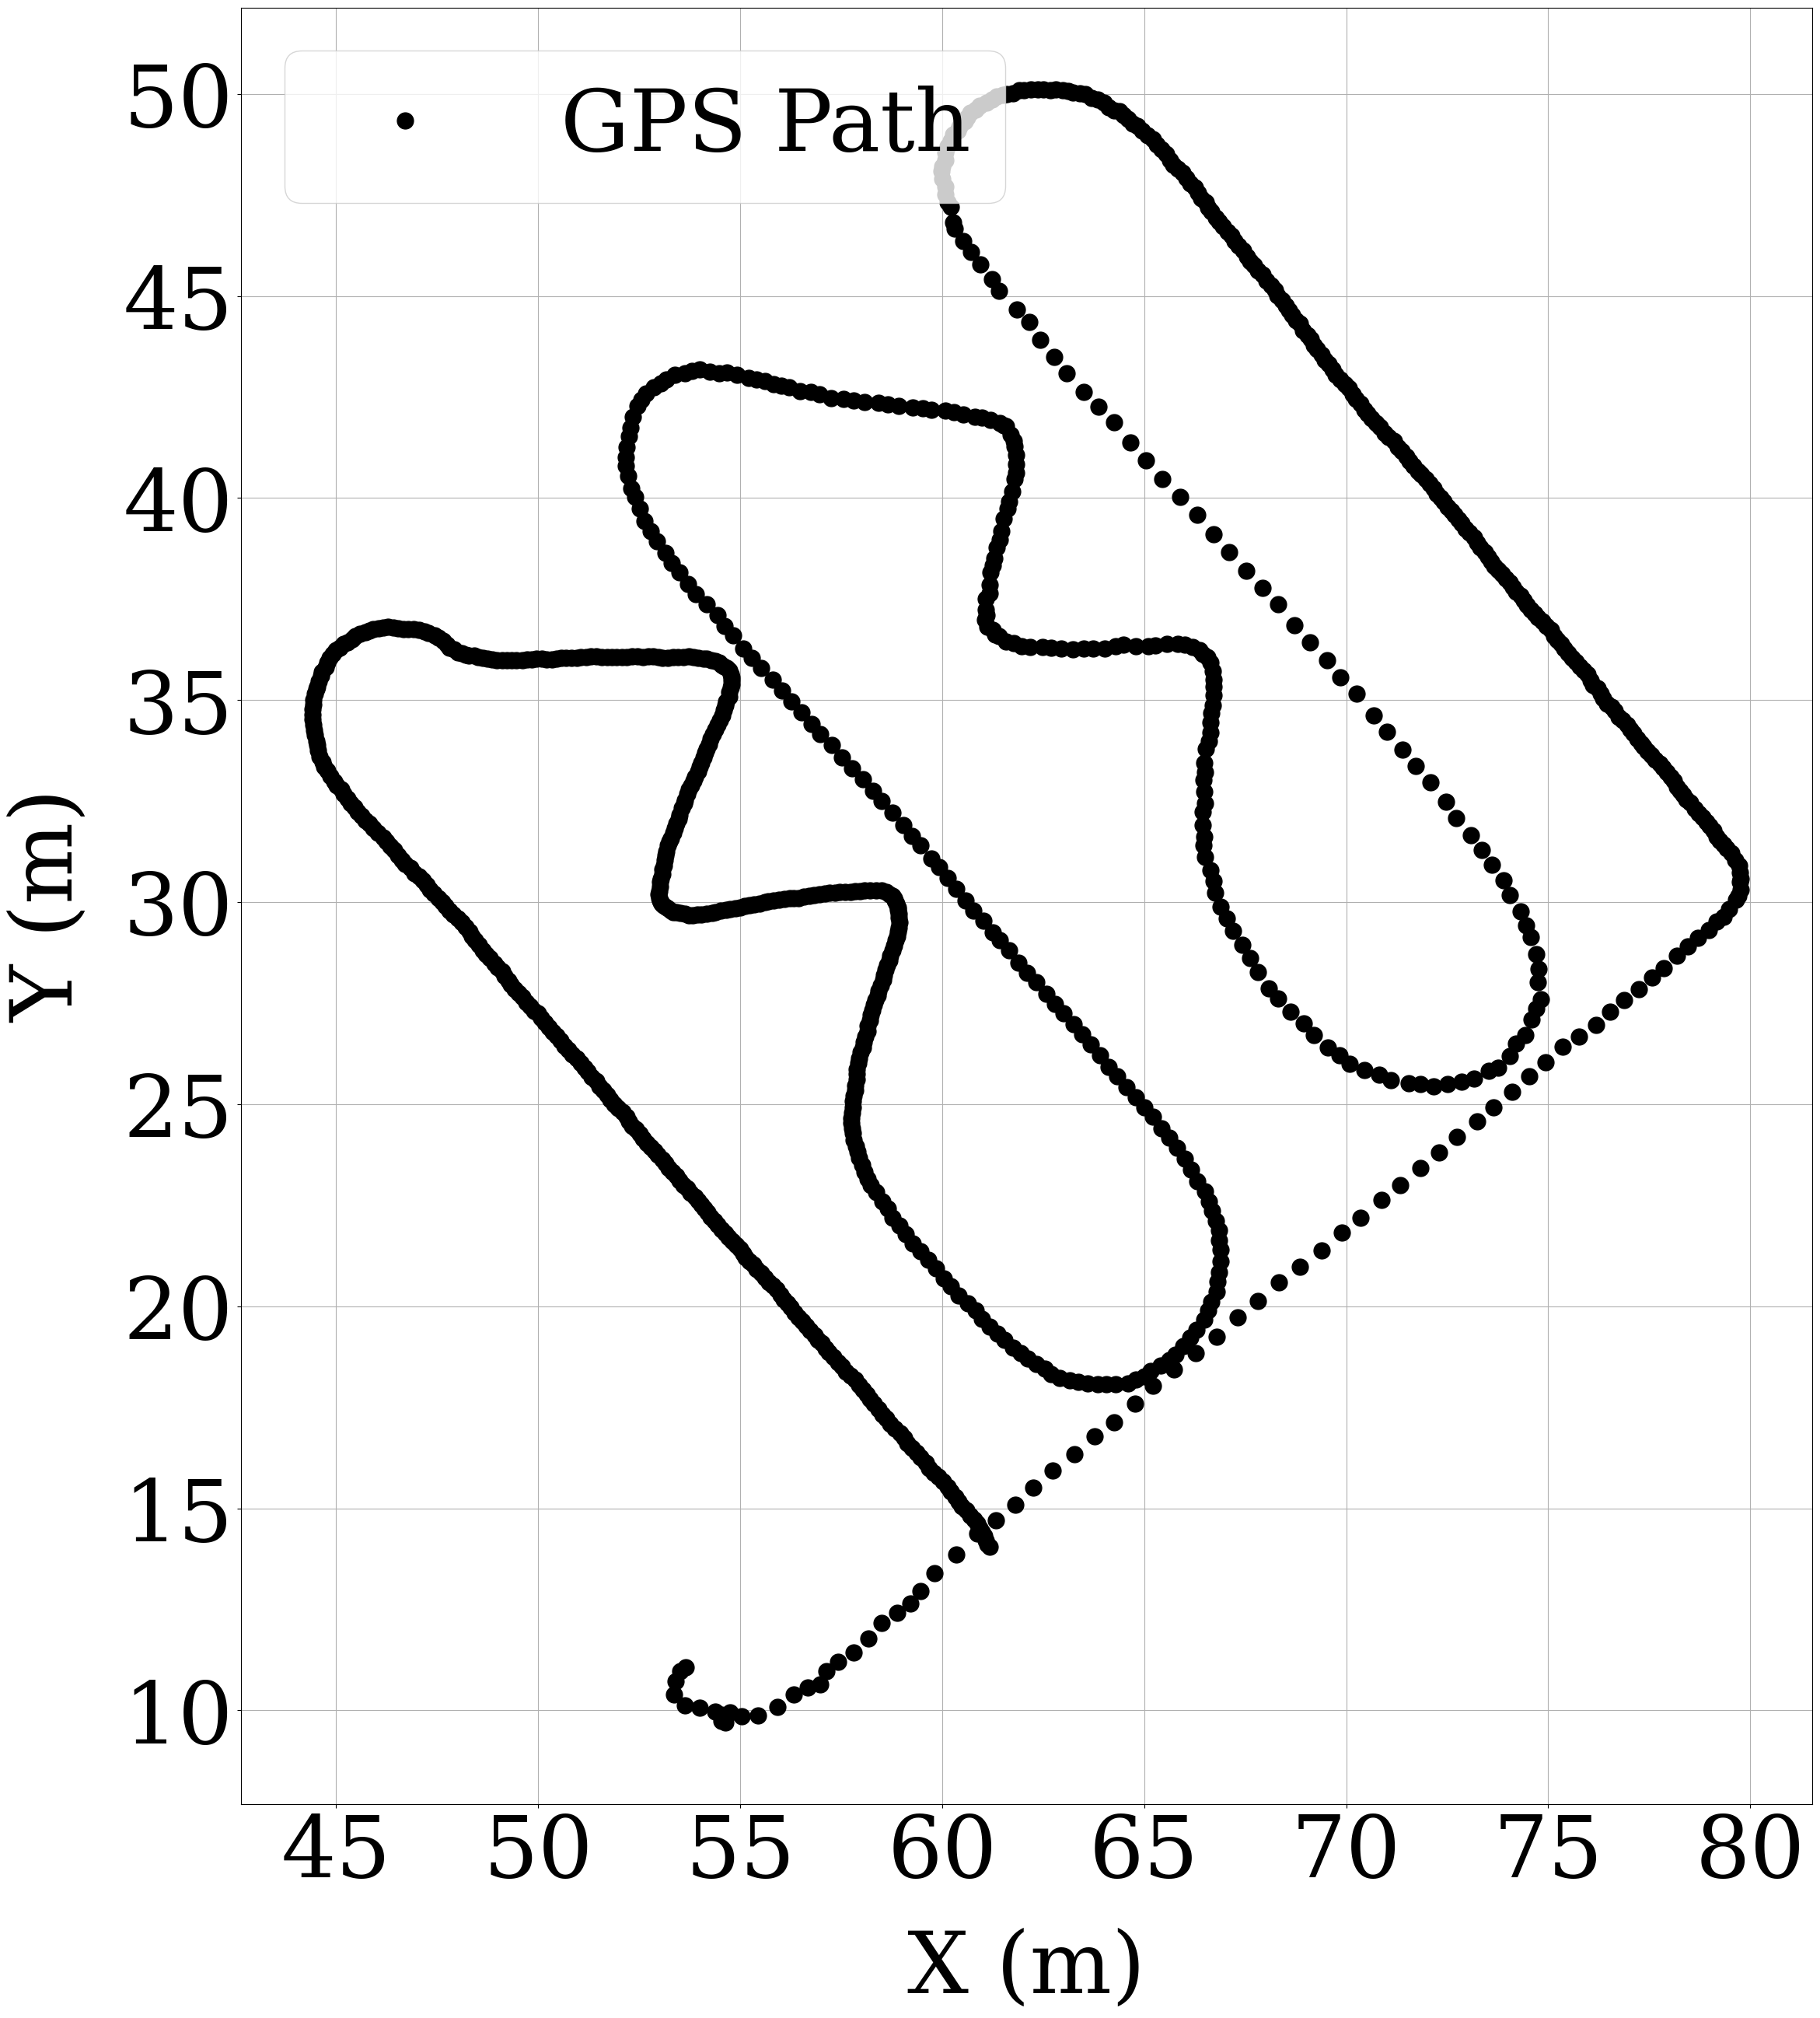

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


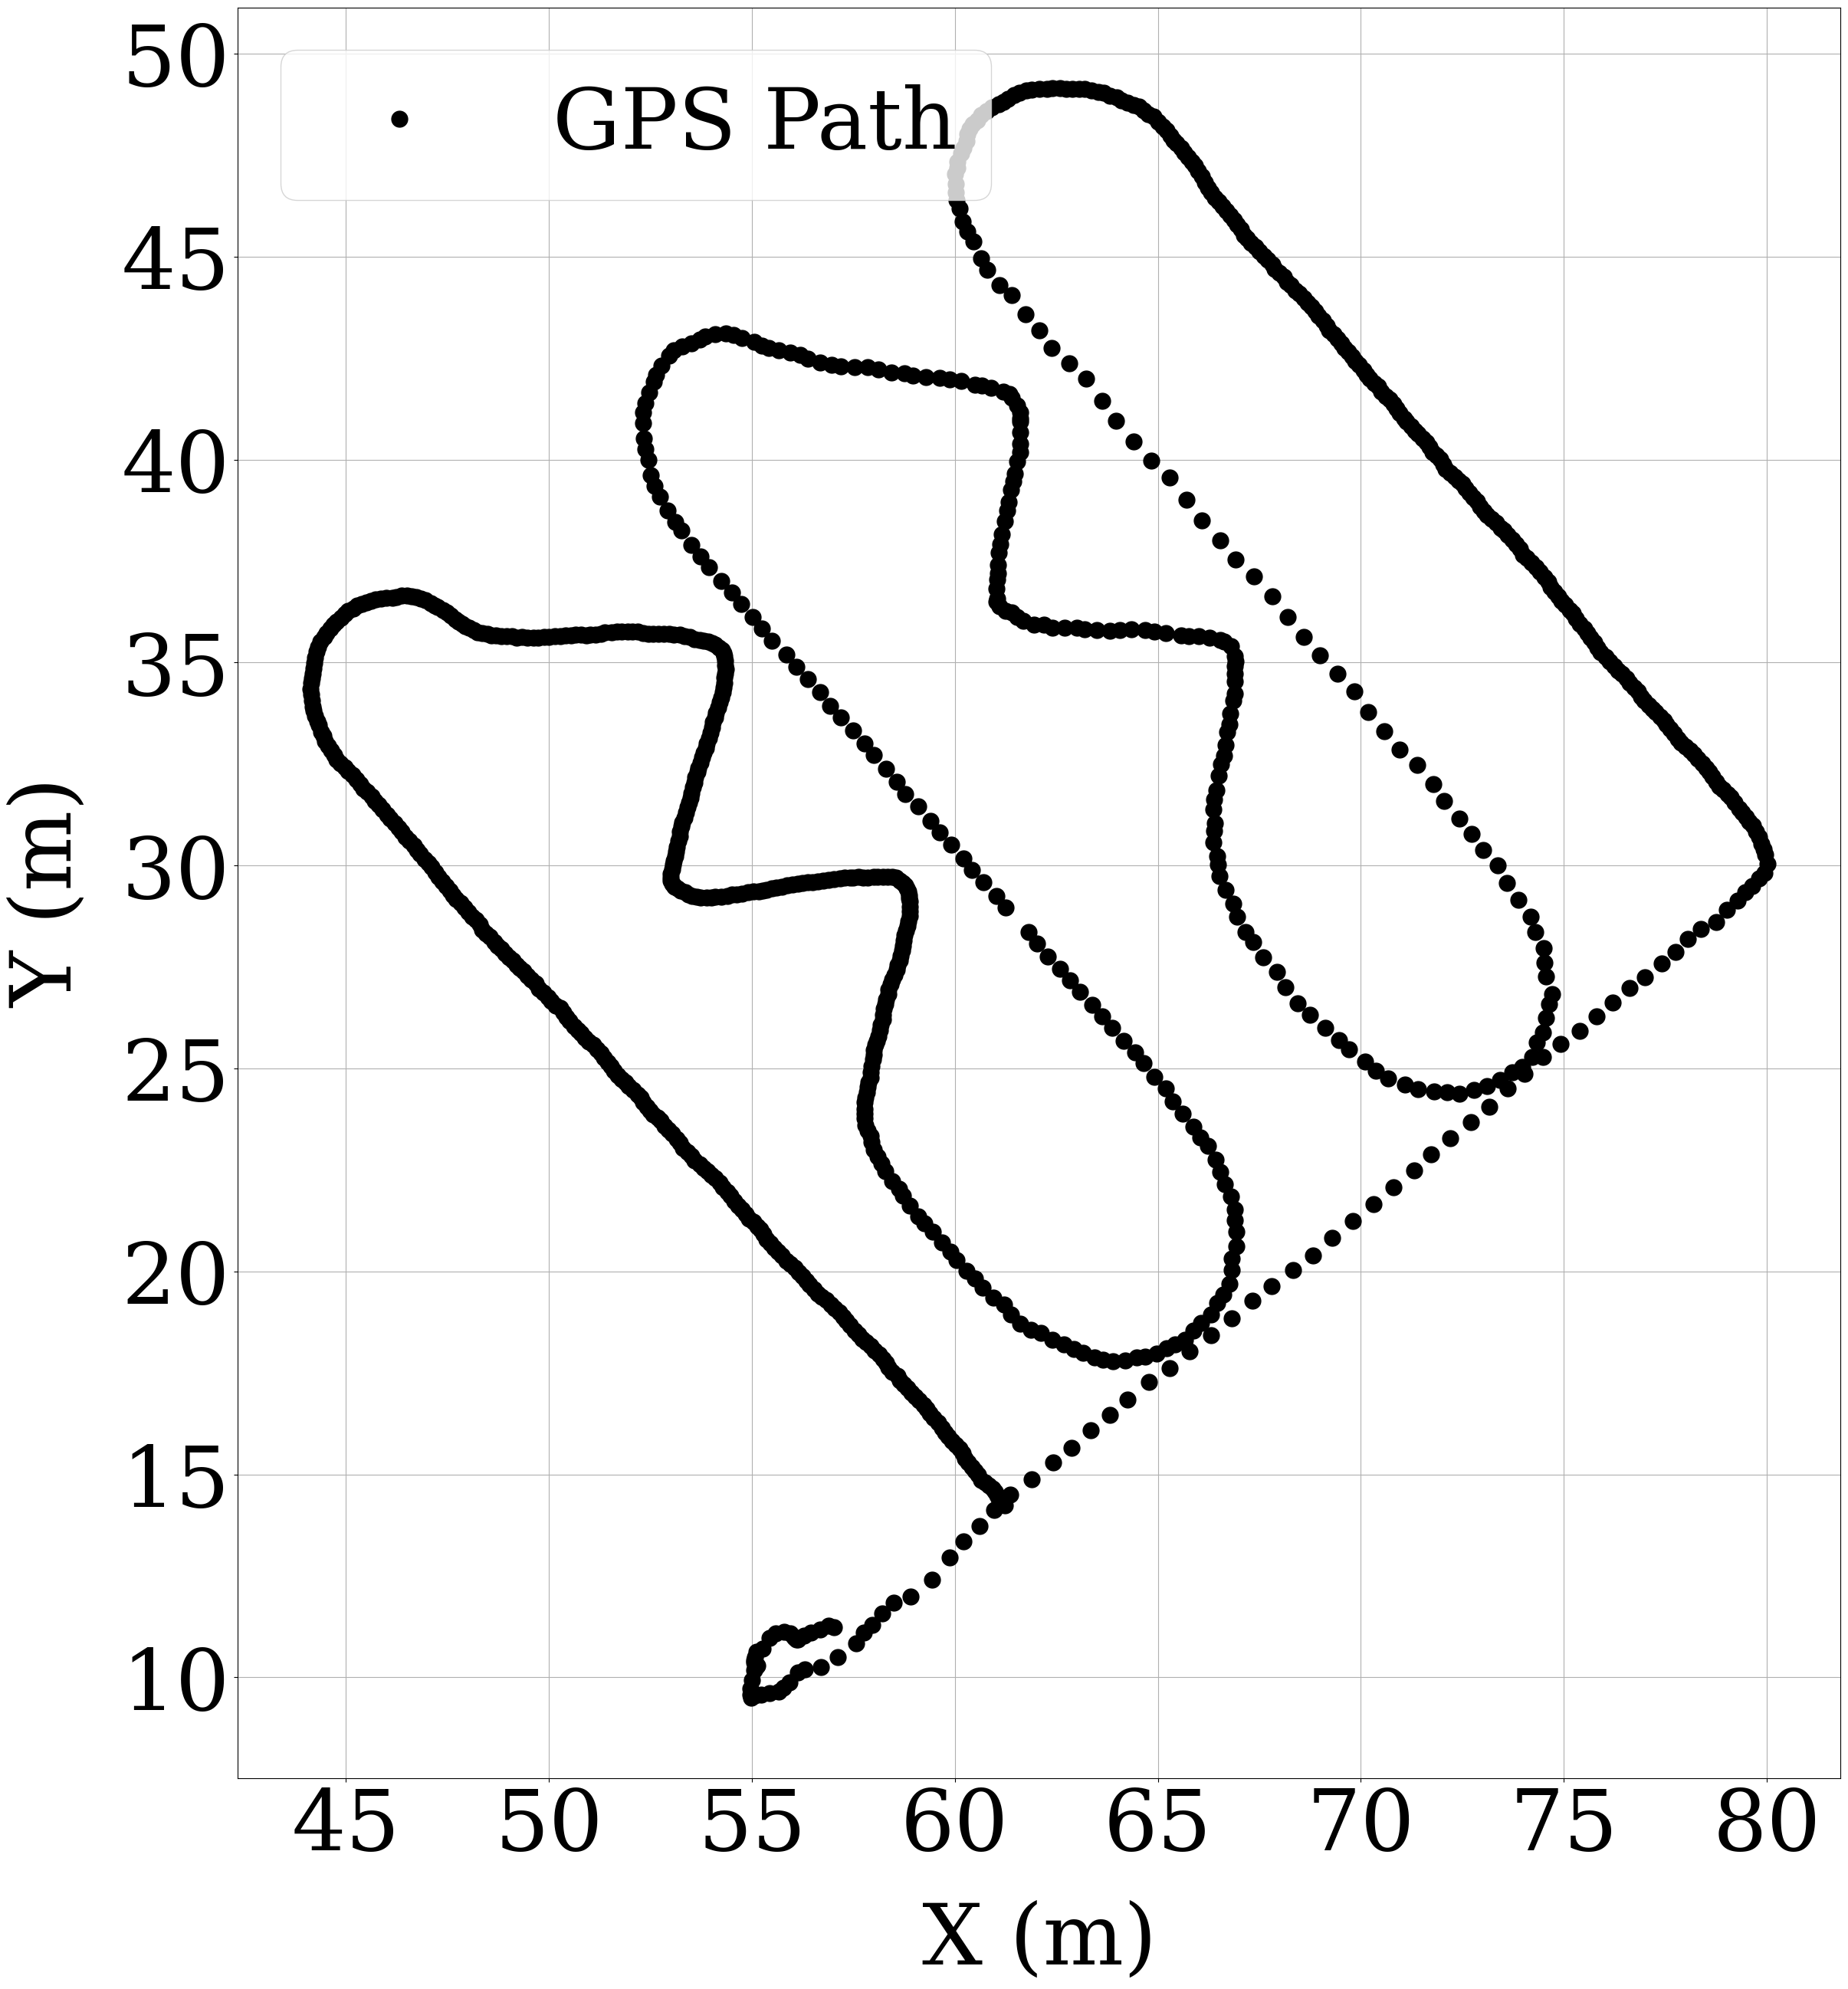

In [24]:
dir_data = Path('./data/20200908/datasets')

dfs_dgps = []
dfs_epts = []

epts_files = []
dgps_files = []
epts_files.extend(dir_data.glob("*circuit_epts*.csv"))
dgps_files.extend(dir_data.glob("*circuit_dgps*.csv"))

for file in epts_files:
    if("trim" not in str(file) and "har" not in str(file)):
        df = pd.read_csv(file)
        dfs_epts.append(df)

for file in dgps_files:
    if("trim" not in str(file) and "har" not in str(file)):
        df = pd.read_csv(file)
        dfs_dgps.append(df)

for i in range(len(dfs_dgps)):
    show_gps(dfs_dgps[i])
    
for i in range(len(dfs_epts)):
    show_gps(dfs_epts[i])
    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


1025, 1025


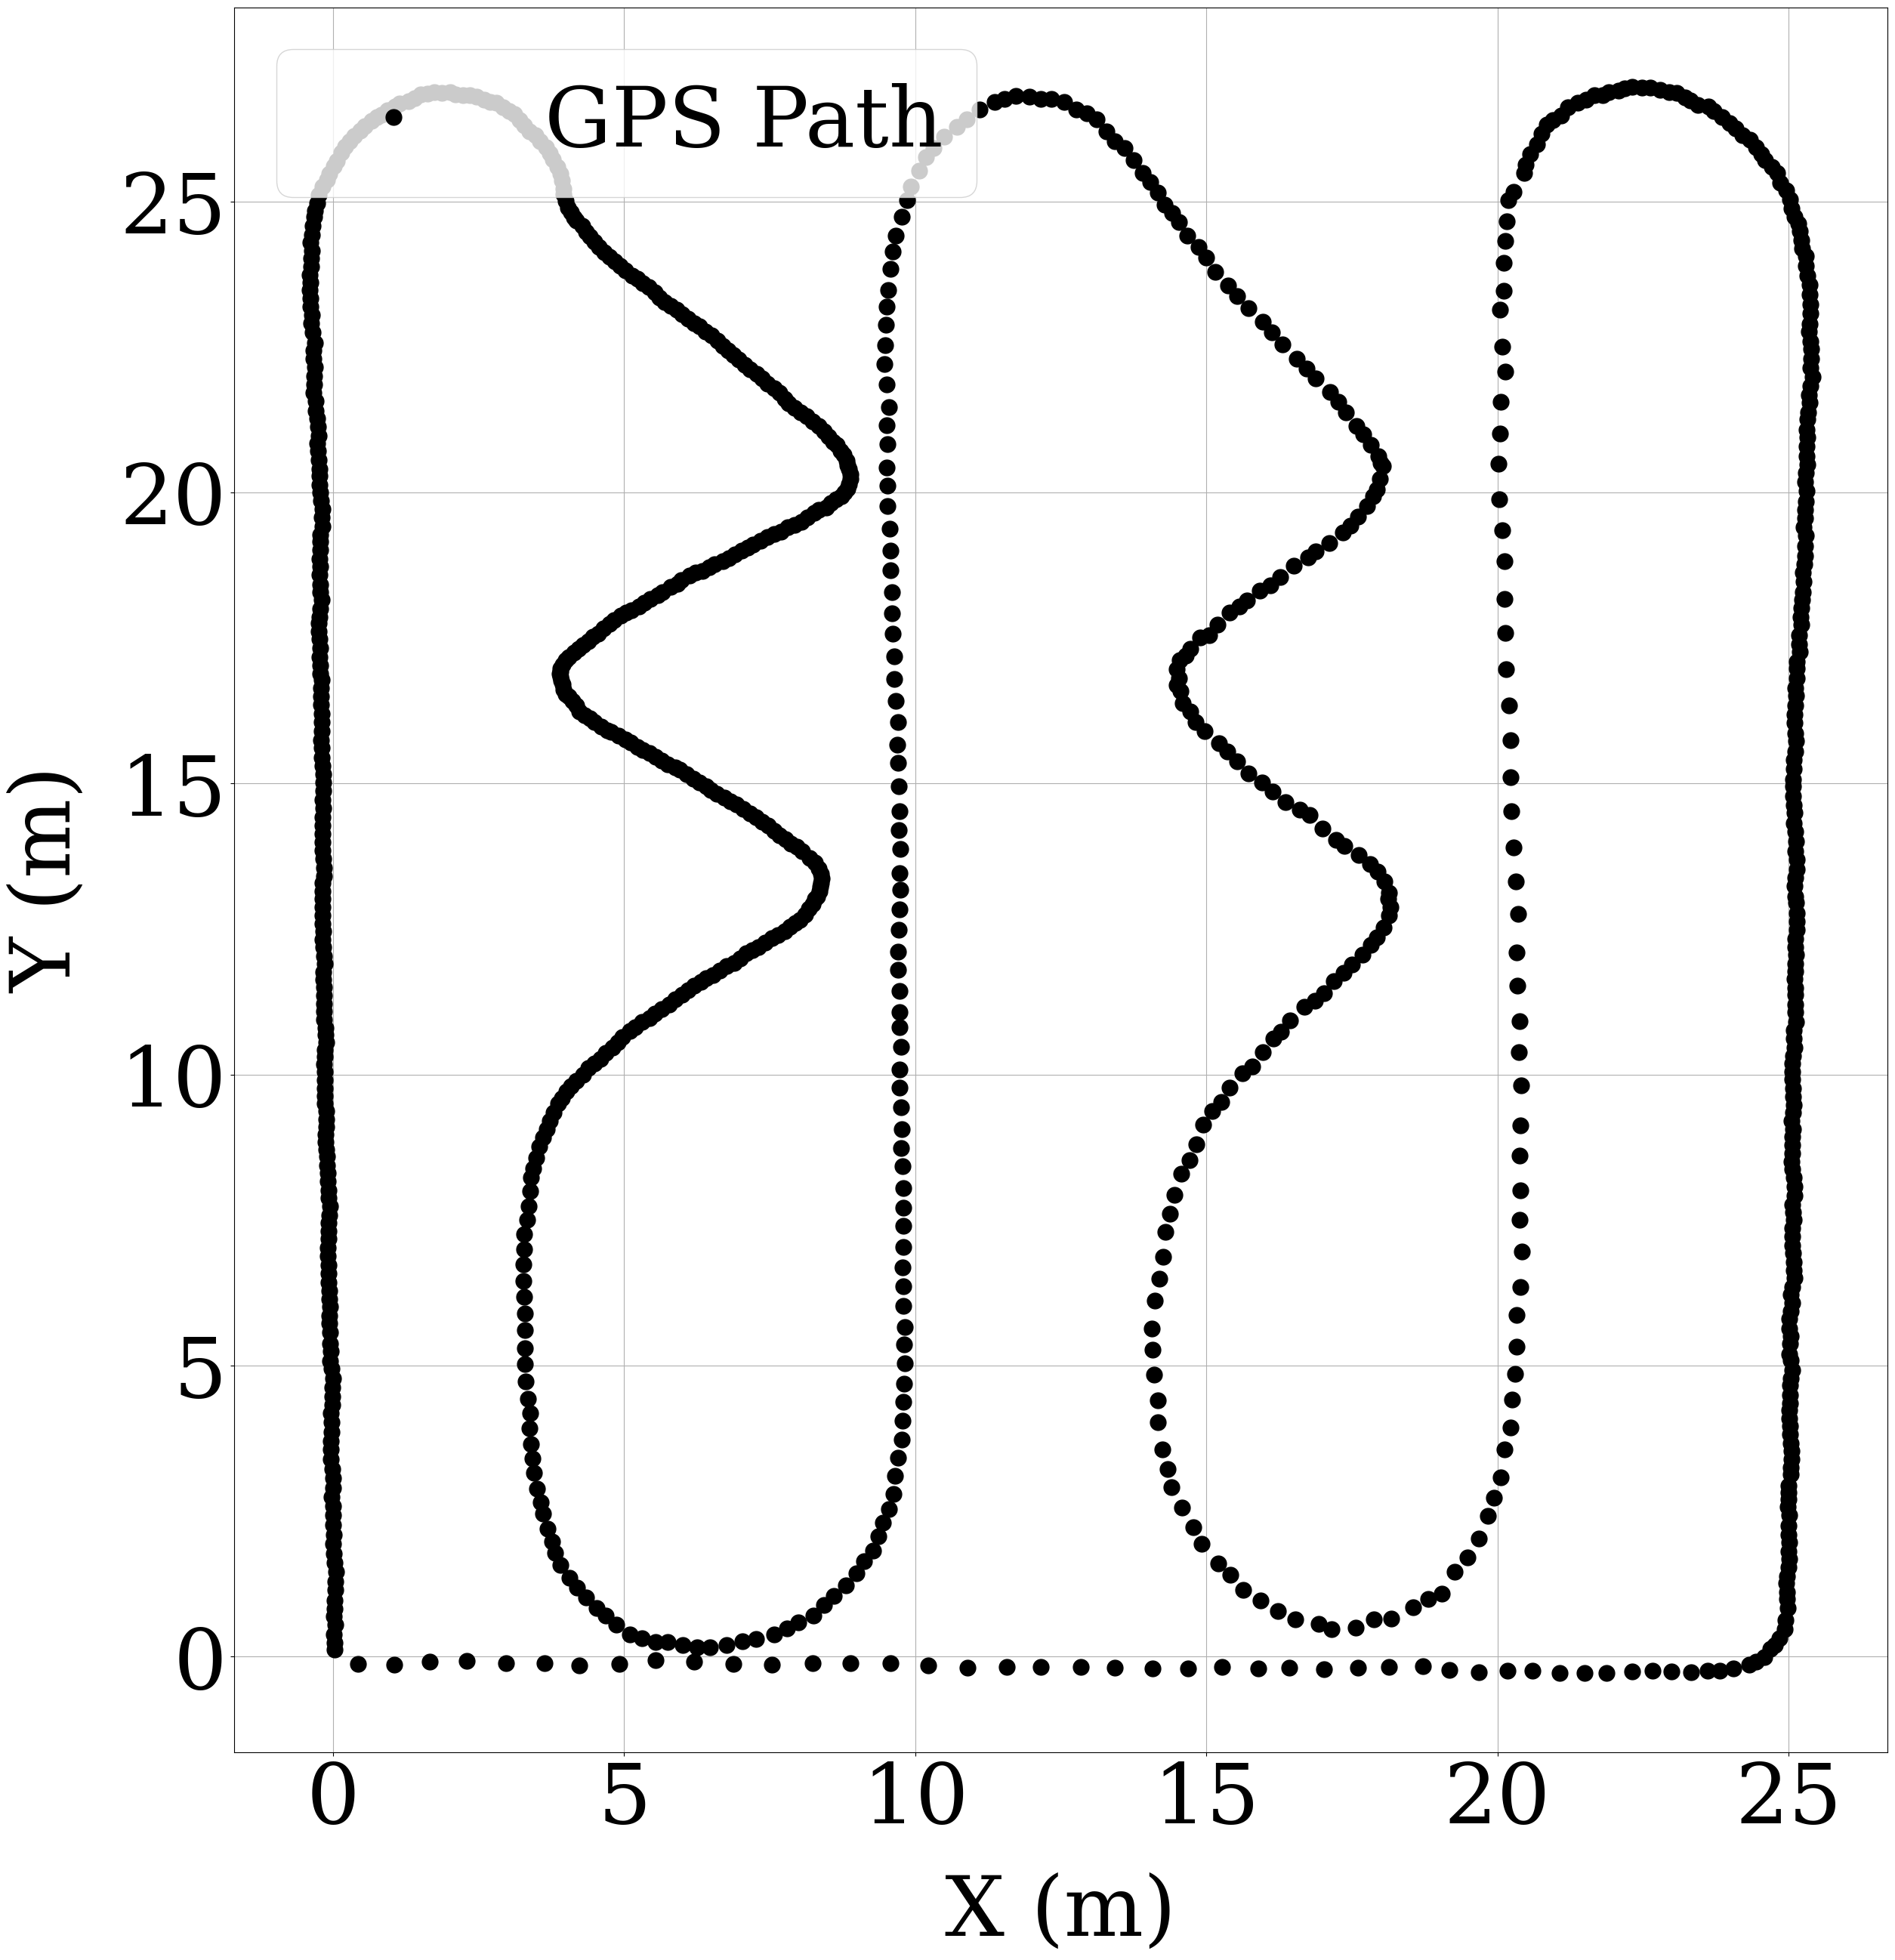

999, 999


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


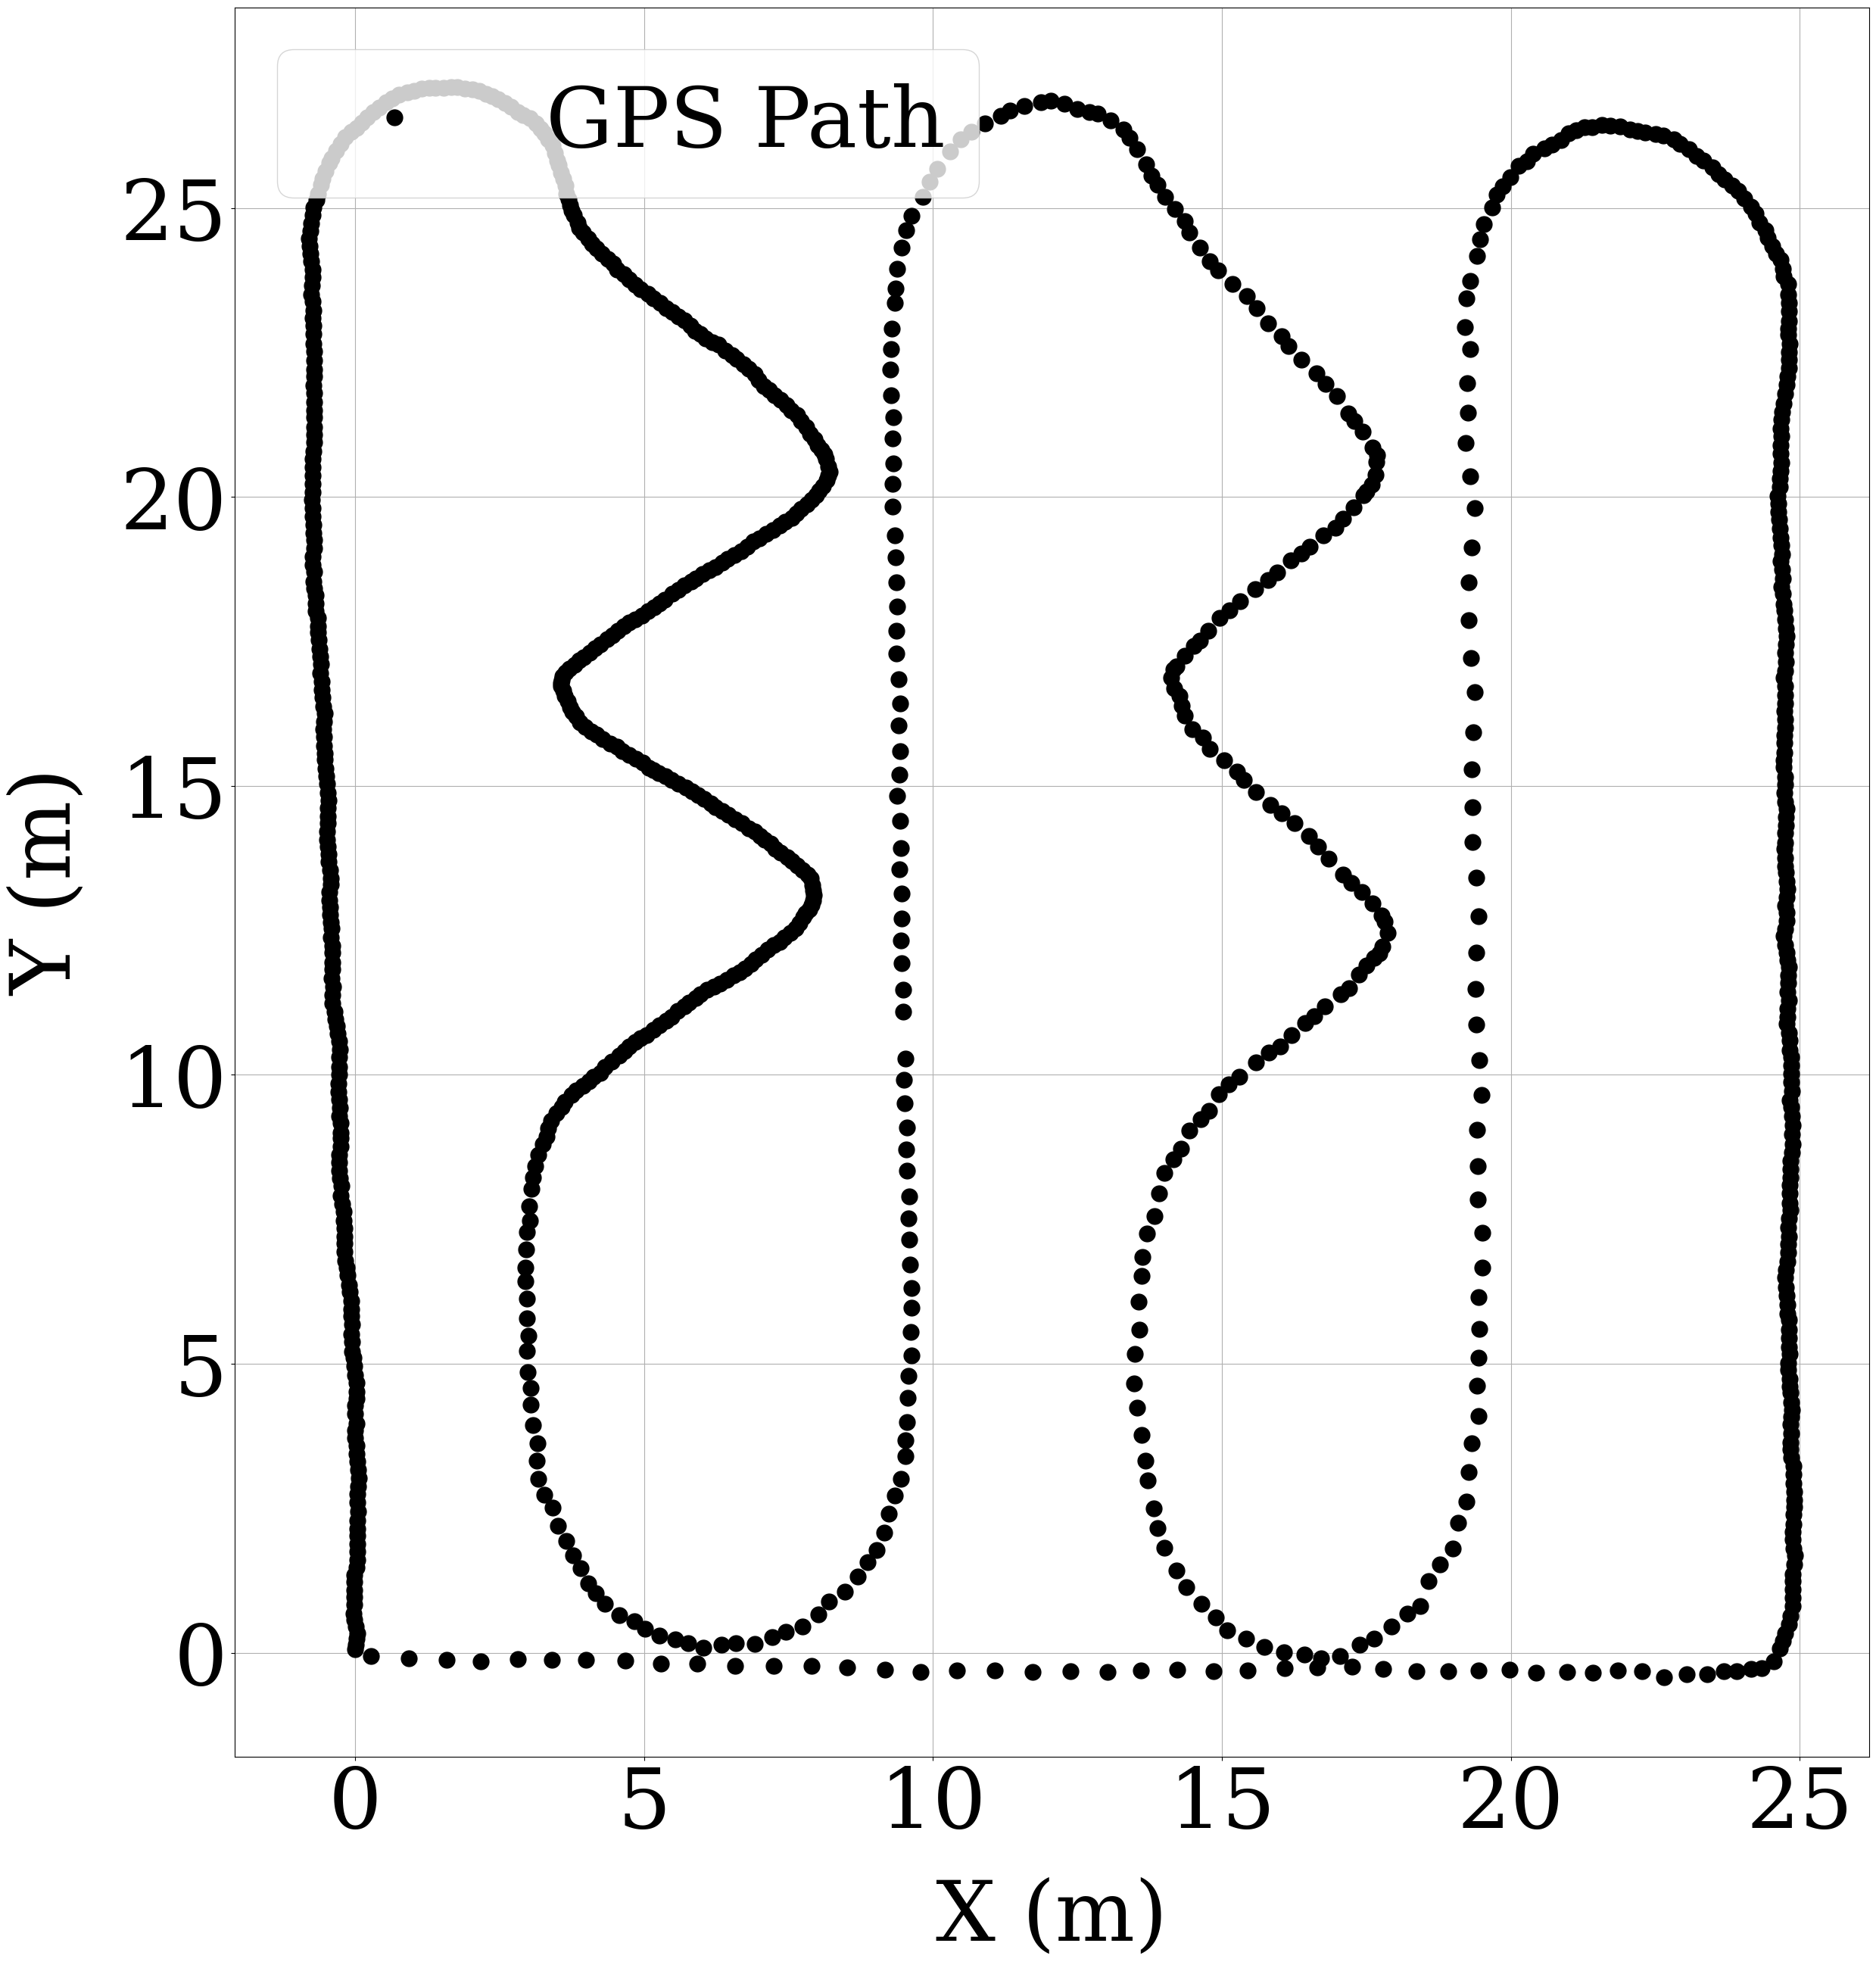

In [25]:
dfs_valid_ = dfs_epts

dfs_epts = []
for df in dfs_valid_:
    dfs_epts.append(df.copy().dropna(subset=['enu_x']))

dfs_true = []
for df in dfs_dgps:
    df[['enu_x','enu_y','speed']].interpolate(method='polynomial', order=2, limit_direction='both', inplace=True)
    dfs_true.append(df.copy())
    
angle = -40
angle = angle * np.pi / 180.0


## Rotate
for i in range(len(dfs_dgps)):
    df_dgps = dfs_true[i]
    df_epts = dfs_epts[i]
    
    init_time = np.maximum(df_dgps.time.iloc[0], df_epts.time.iloc[0])
    end_time = np.minimum(df_dgps.time.iloc[-1], df_epts.time.iloc[-1])
    
    dfs_true[i] = df_dgps.loc[(df_dgps['time']>=init_time) & (df_dgps['time']<=end_time)].reset_index(drop=True)
    dfs_epts[i] = df_epts.loc[(df_epts['time']>=init_time) & (df_epts['time']<=end_time)].reset_index(drop=True)

for i in range(len(dfs_dgps)):
    enux = dfs_true[i]['enu_x'].to_numpy()
    enuy = dfs_true[i]['enu_y'].to_numpy()
    
    x = np.cos(angle)*enux - np.sin(angle)*enuy
    y = np.sin(angle)*enux + np.cos(angle)*enuy
    
    dfs_true[i]['enu_x'] = x - x[0]
    dfs_true[i]['enu_y'] = y - y[0]
    
    
    enux = dfs_epts[i]['enu_x'].to_numpy()
    enuy = dfs_epts[i]['enu_y'].to_numpy()
    
    x = np.cos(angle)*enux - np.sin(angle)*enuy
    y = np.sin(angle)*enux + np.cos(angle)*enuy
    
    dfs_epts[i]['enu_x'] = x - x[0]
    dfs_epts[i]['enu_y'] = y - y[0]
#    print(f"{len(dfs_true[i])}, {len(dfs_epts[i])}")
    #show_gps(dfs_true[i], enu_format=1)
    #show_gps(dfs_epts[i], enu_format=1)

## Trim
trim_method = 2
if(trim_method == 1):
    for i in range(len(dfs_dgps)):
        end_drop_epts = dfs_epts[i].loc[ (dfs_epts[i]['enu_x']<dfs_epts[i]['enu_x'][0]) & (dfs_epts[i]['time'] > dfs_epts[i].iloc[-50]['time'])].index
        end_drop_dgps = dfs_true[i].loc[ (dfs_true[i]['enu_x']<dfs_true[i]['enu_x'][0]) & (dfs_true[i]['time'] > dfs_true[i].iloc[-50]['time'])].index

        dfs_epts[i].drop(inplace=True, index=end_drop_epts)
        dfs_true[i].drop(inplace=True, index=end_drop_dgps)

        start_drop_epts = dfs_epts[i].loc[ (dfs_epts[i]['enu_y']<dfs_epts[i].iloc[-1]['enu_y']) & (dfs_epts[i]['time'] < dfs_epts[i].iloc[50]['time'])].index
        start_drop_dgps = dfs_true[i].loc[ (dfs_true[i]['enu_y']<dfs_true[i].iloc[-1]['enu_y']) & (dfs_true[i]['time'] < dfs_true[i].iloc[50]['time'])].index

        dfs_epts[i].drop(inplace=True, index=start_drop_epts)
        dfs_true[i].drop(inplace=True, index=start_drop_dgps)

        dfs_epts[i].reset_index(drop=True, inplace=True)
        dfs_true[i].reset_index(drop=True, inplace=True)

        dfs_true[i]['enu_x'] -= dfs_true[i].loc[0,'enu_x']
        dfs_true[i]['enu_y'] -= dfs_true[i].loc[0,'enu_y']
        dfs_epts[i]['enu_x'] -= dfs_epts[i].loc[0,'enu_x']
        dfs_epts[i]['enu_y'] -= dfs_epts[i].loc[0,'enu_y']

        print(f"{len(dfs_true[i])}, {len(dfs_epts[i])}")
    #    show_gps(dfs_epts[i], enu_format=1)
    
elif(trim_method == 2):
    # Based on EPTS
    for i in range(len(dfs_dgps)):
        end_drop_epts = dfs_epts[i].loc[ (dfs_epts[i]['enu_x']<dfs_epts[i]['enu_x'][0]) & (dfs_epts[i]['time'] > dfs_epts[i].iloc[-50]['time'])].index
        dfs_epts[i].drop(inplace=True, index=end_drop_epts)

        start_drop_epts = dfs_epts[i].loc[ (dfs_epts[i]['enu_y']<dfs_epts[i].iloc[-1]['enu_y']) & (dfs_epts[i]['time'] < dfs_epts[i].iloc[50]['time'])].index
        dfs_epts[i].drop(inplace=True, index=start_drop_epts)

        dfs_true[i] = dfs_true[i].loc[dfs_epts[i].index]

        dfs_epts[i].reset_index(drop=True, inplace=True)
        dfs_true[i].reset_index(drop=True, inplace=True)

        dfs_epts[i]['enu_x'] -= dfs_epts[i].loc[0,'enu_x']
        dfs_epts[i]['enu_y'] -= dfs_epts[i].loc[0,'enu_y']

        dfs_true[i]['enu_x'] -= dfs_true[i].loc[0,'enu_x']
        dfs_true[i]['enu_y'] -= dfs_true[i].loc[0,'enu_y']

        print(f"{len(dfs_true[i])}, {len(dfs_epts[i])}")
        show_gps(dfs_epts[i], enu_format=1)
        #show_gps_comp(dfs_epts[i], dfs_true[i], idx_start=1, idx_end=None, enu_format=1)

elif(trim_method == 3):
    # Based on DGPS
    for i in range(len(dfs_dgps)):
        end_drop_dgps = dfs_true[i].loc[ (dfs_true[i]['enu_x']<dfs_true[i]['enu_x'][0]) & (dfs_true[i]['time'] > dfs_true[i].iloc[-50]['time'])].index
        dfs_true[i].drop(inplace=True, index=end_drop_dgps)

        start_drop_dgps = dfs_true[i].loc[ (dfs_true[i]['enu_y']<dfs_true[i].iloc[-1]['enu_y']) & (dfs_true[i]['time'] < dfs_true[i].iloc[50]['time'])].index
        dfs_true[i].drop(inplace=True, index=start_drop_dgps)

        dfs_epts[i] = dfs_epts[i].loc[dfs_true[i].index]

        dfs_epts[i].reset_index(drop=True, inplace=True)
        dfs_true[i].reset_index(drop=True, inplace=True)

        dfs_true[i]['enu_x'] -= dfs_true[i].loc[0,'enu_x']
        dfs_true[i]['enu_y'] -= dfs_true[i].loc[0,'enu_y']

        dfs_epts[i]['enu_x'] -= dfs_epts[i].loc[0,'enu_x']
        dfs_epts[i]['enu_y'] -= dfs_epts[i].loc[0,'enu_y']

        print(f"{len(dfs_true[i])}, {len(dfs_epts[i])}")
    #    show_gps(dfs_epts[i], enu_format=1)

for name in epts_files:
    dfs_epts[i].to_csv(dir_data/Path(name.stem+'_trim.csv'))

for name in dgps_files:
    dfs_dgps[i].to_csv(dir_data/Path(name.stem+'_trim.csv'))

Meean errors | vErr: 0.27605, pErr: 0.71611, dErr: 0.02596
RMSE values | vRMSE: 0.47079, pRMSE: 0.95386, dRMSE: 0.03826
Meean errors | vErr: 0.39296, pErr: 1.85948, dErr: 0.03603
RMSE values | vRMSE: 0.74799, pRMSE: 2.57030, dRMSE: 0.06369


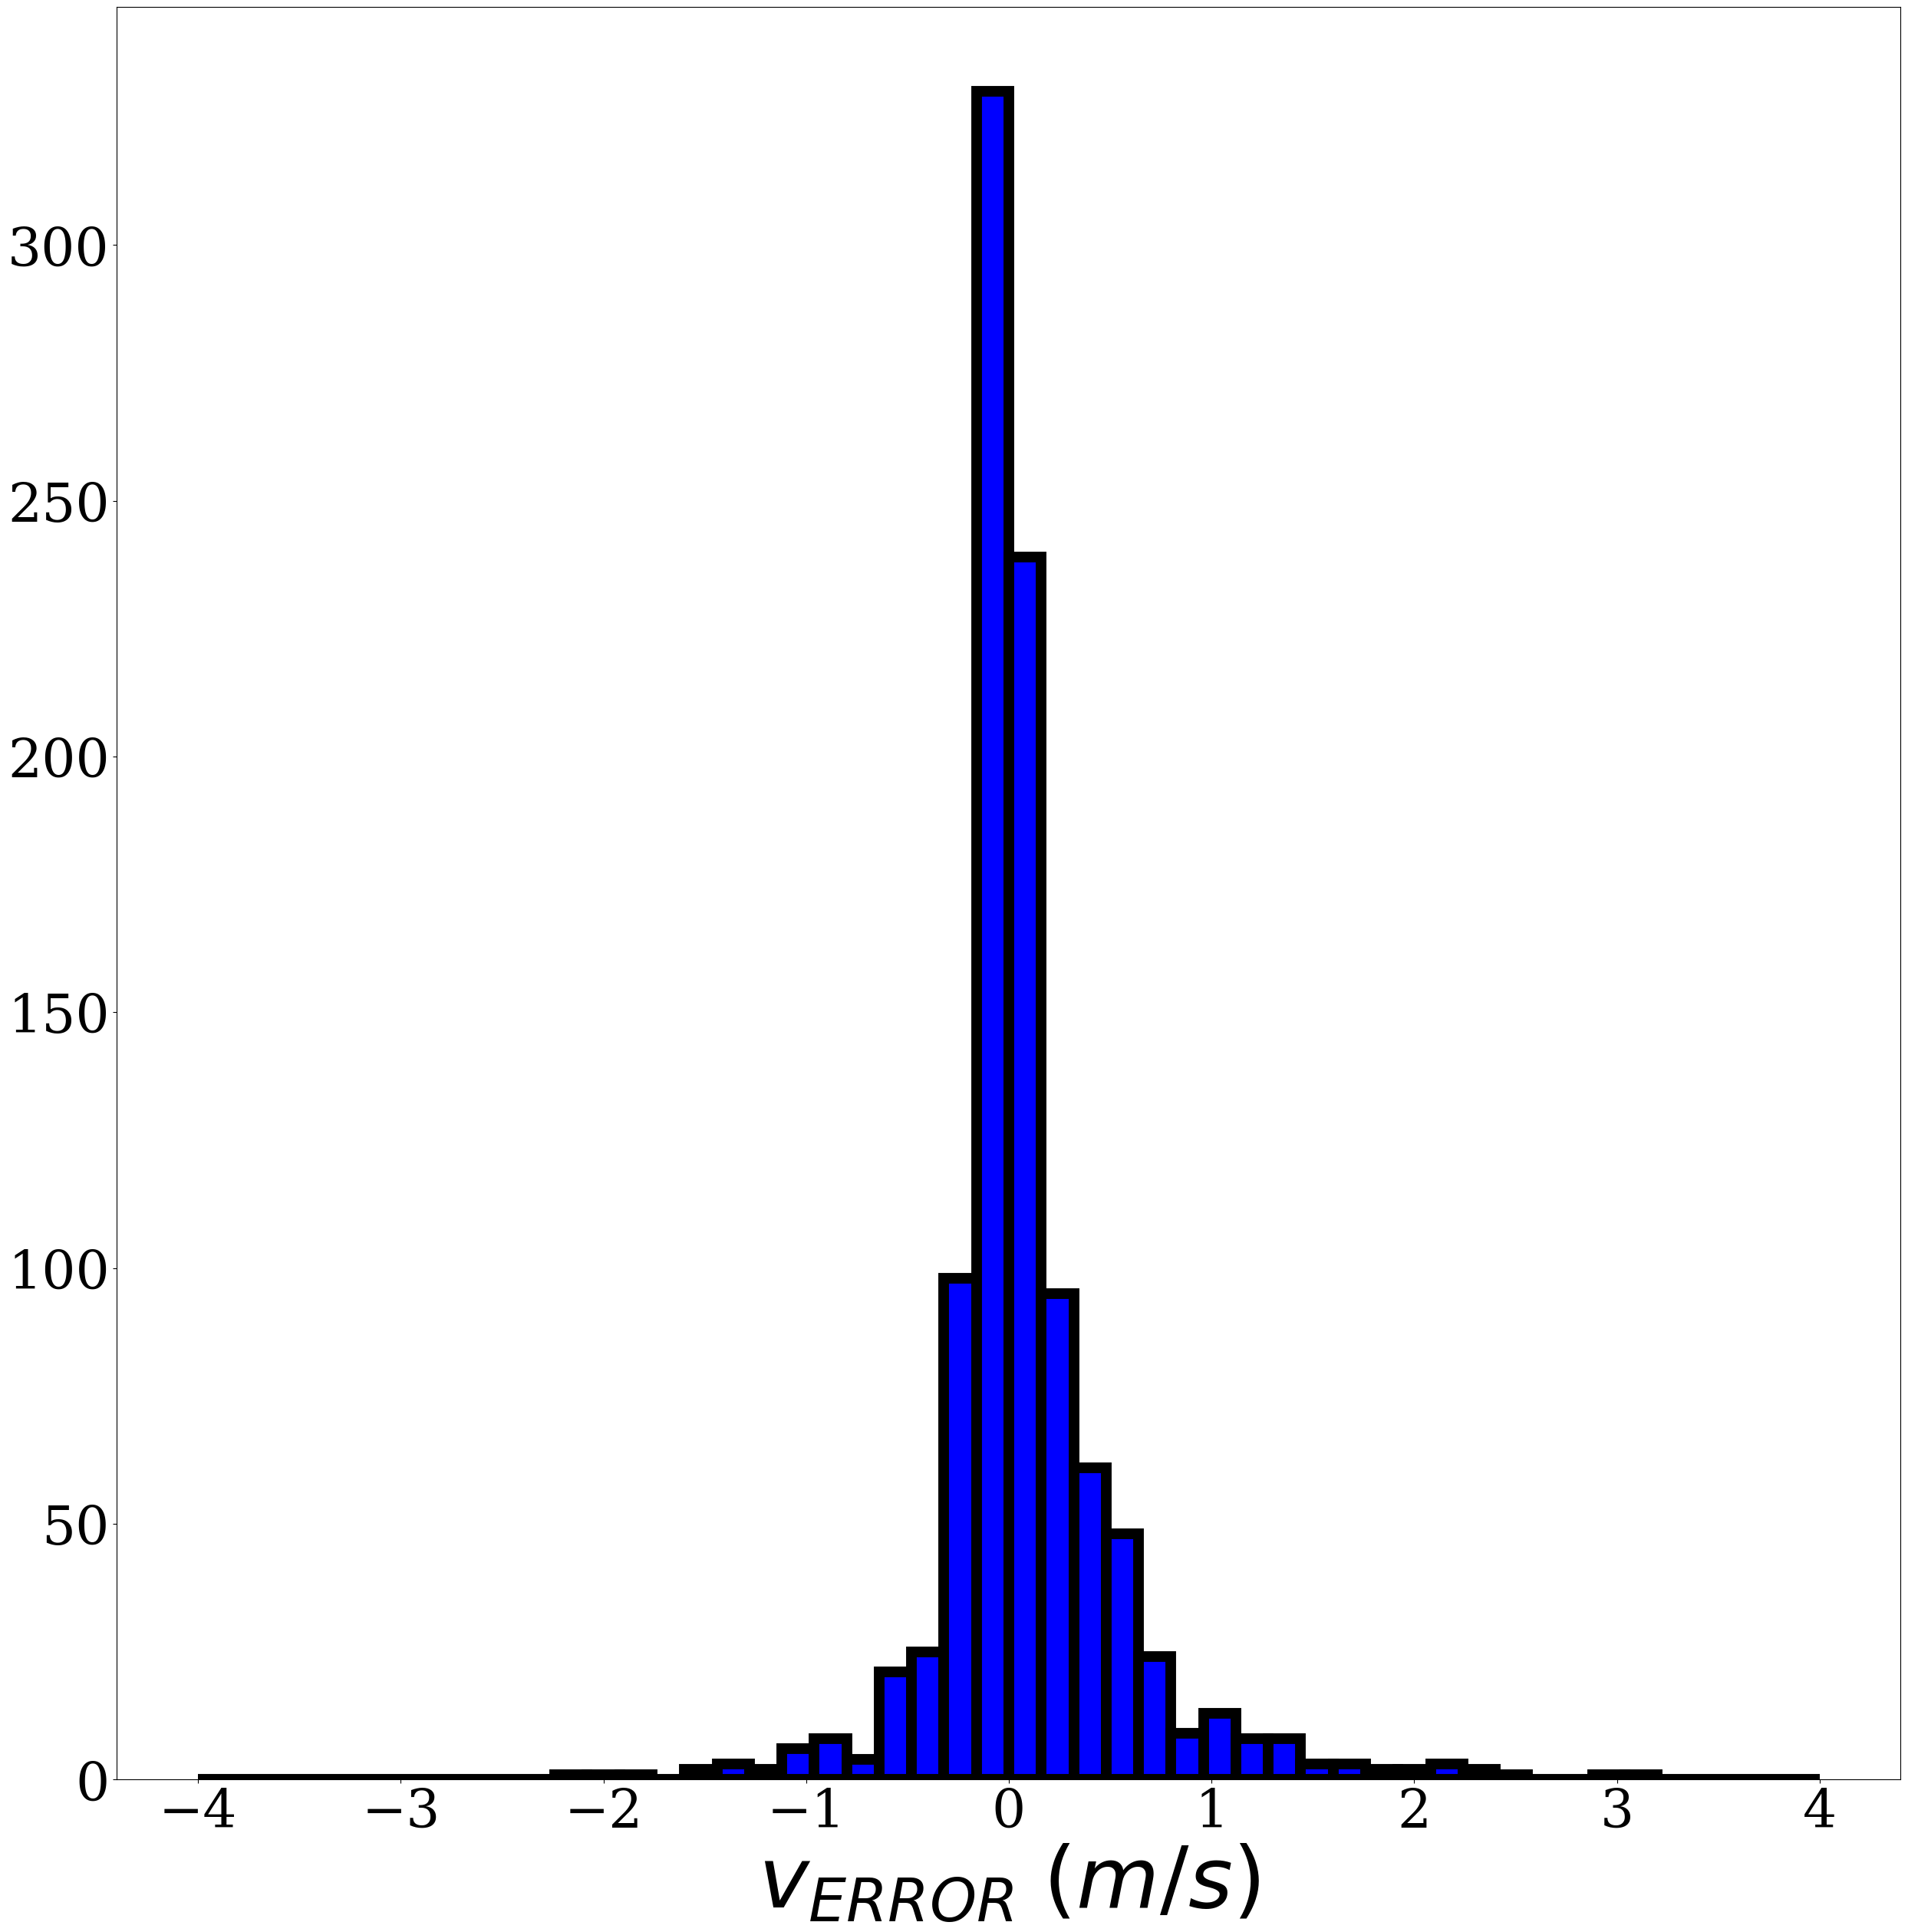

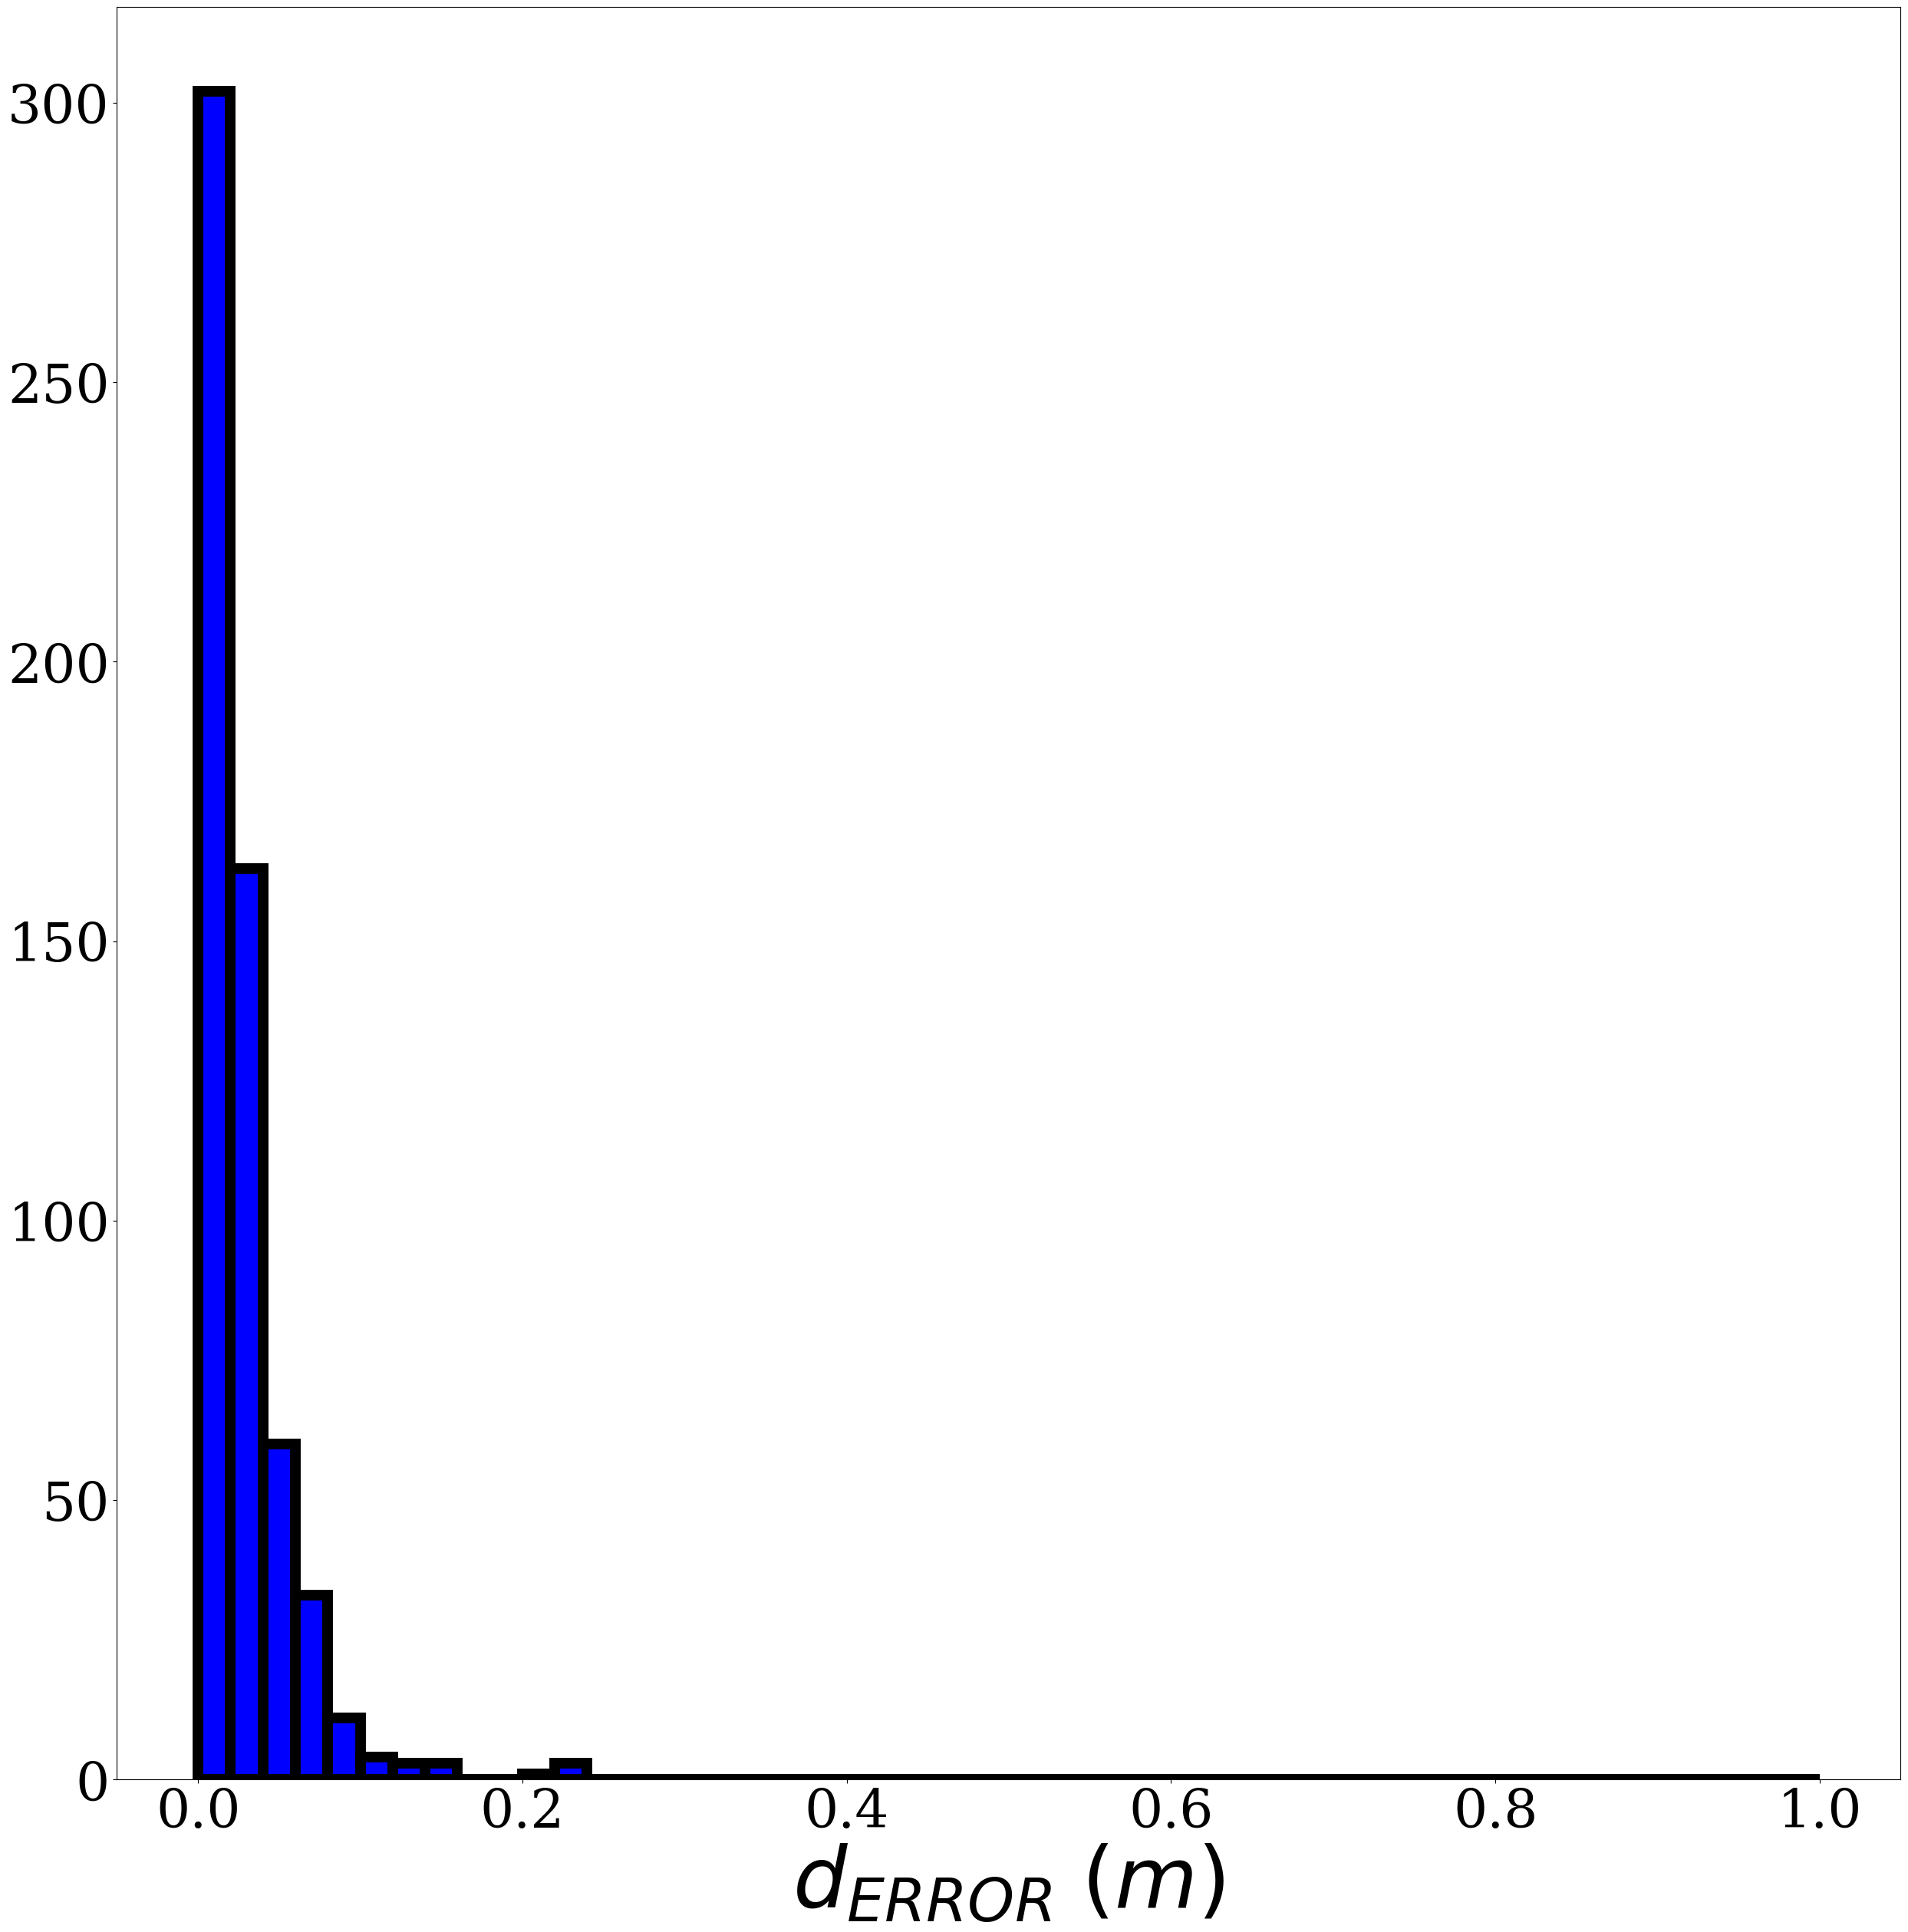

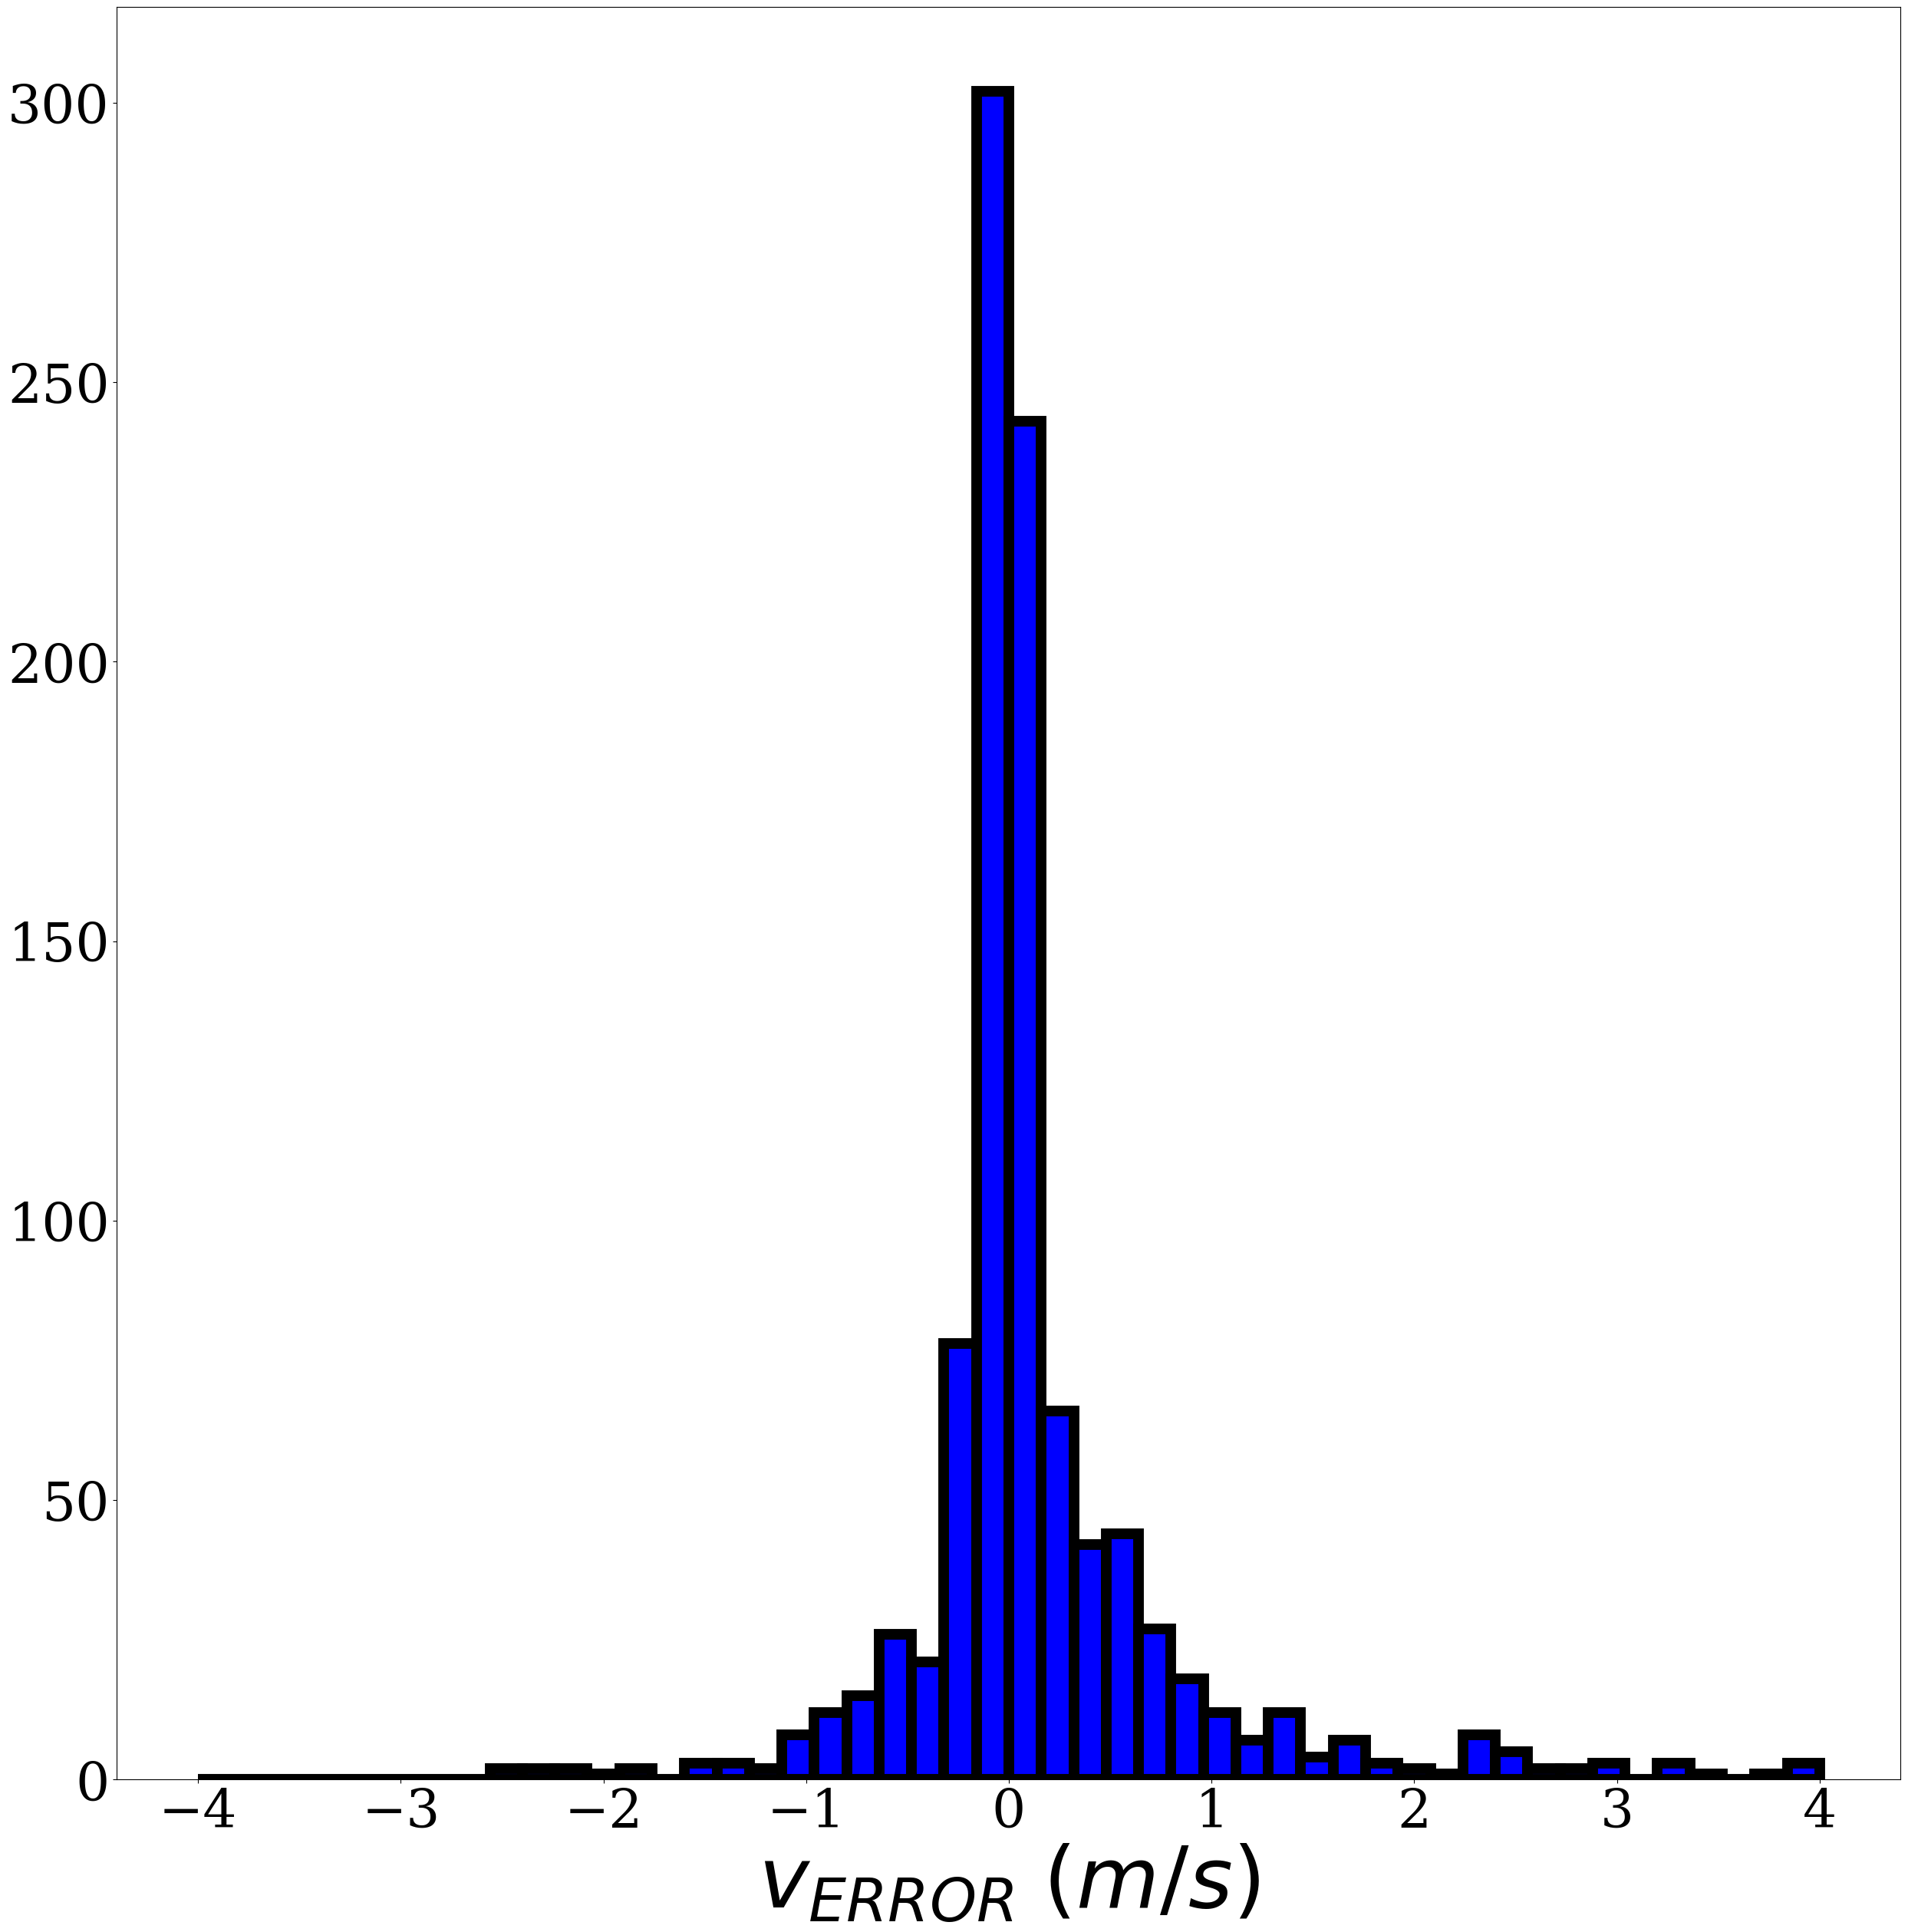

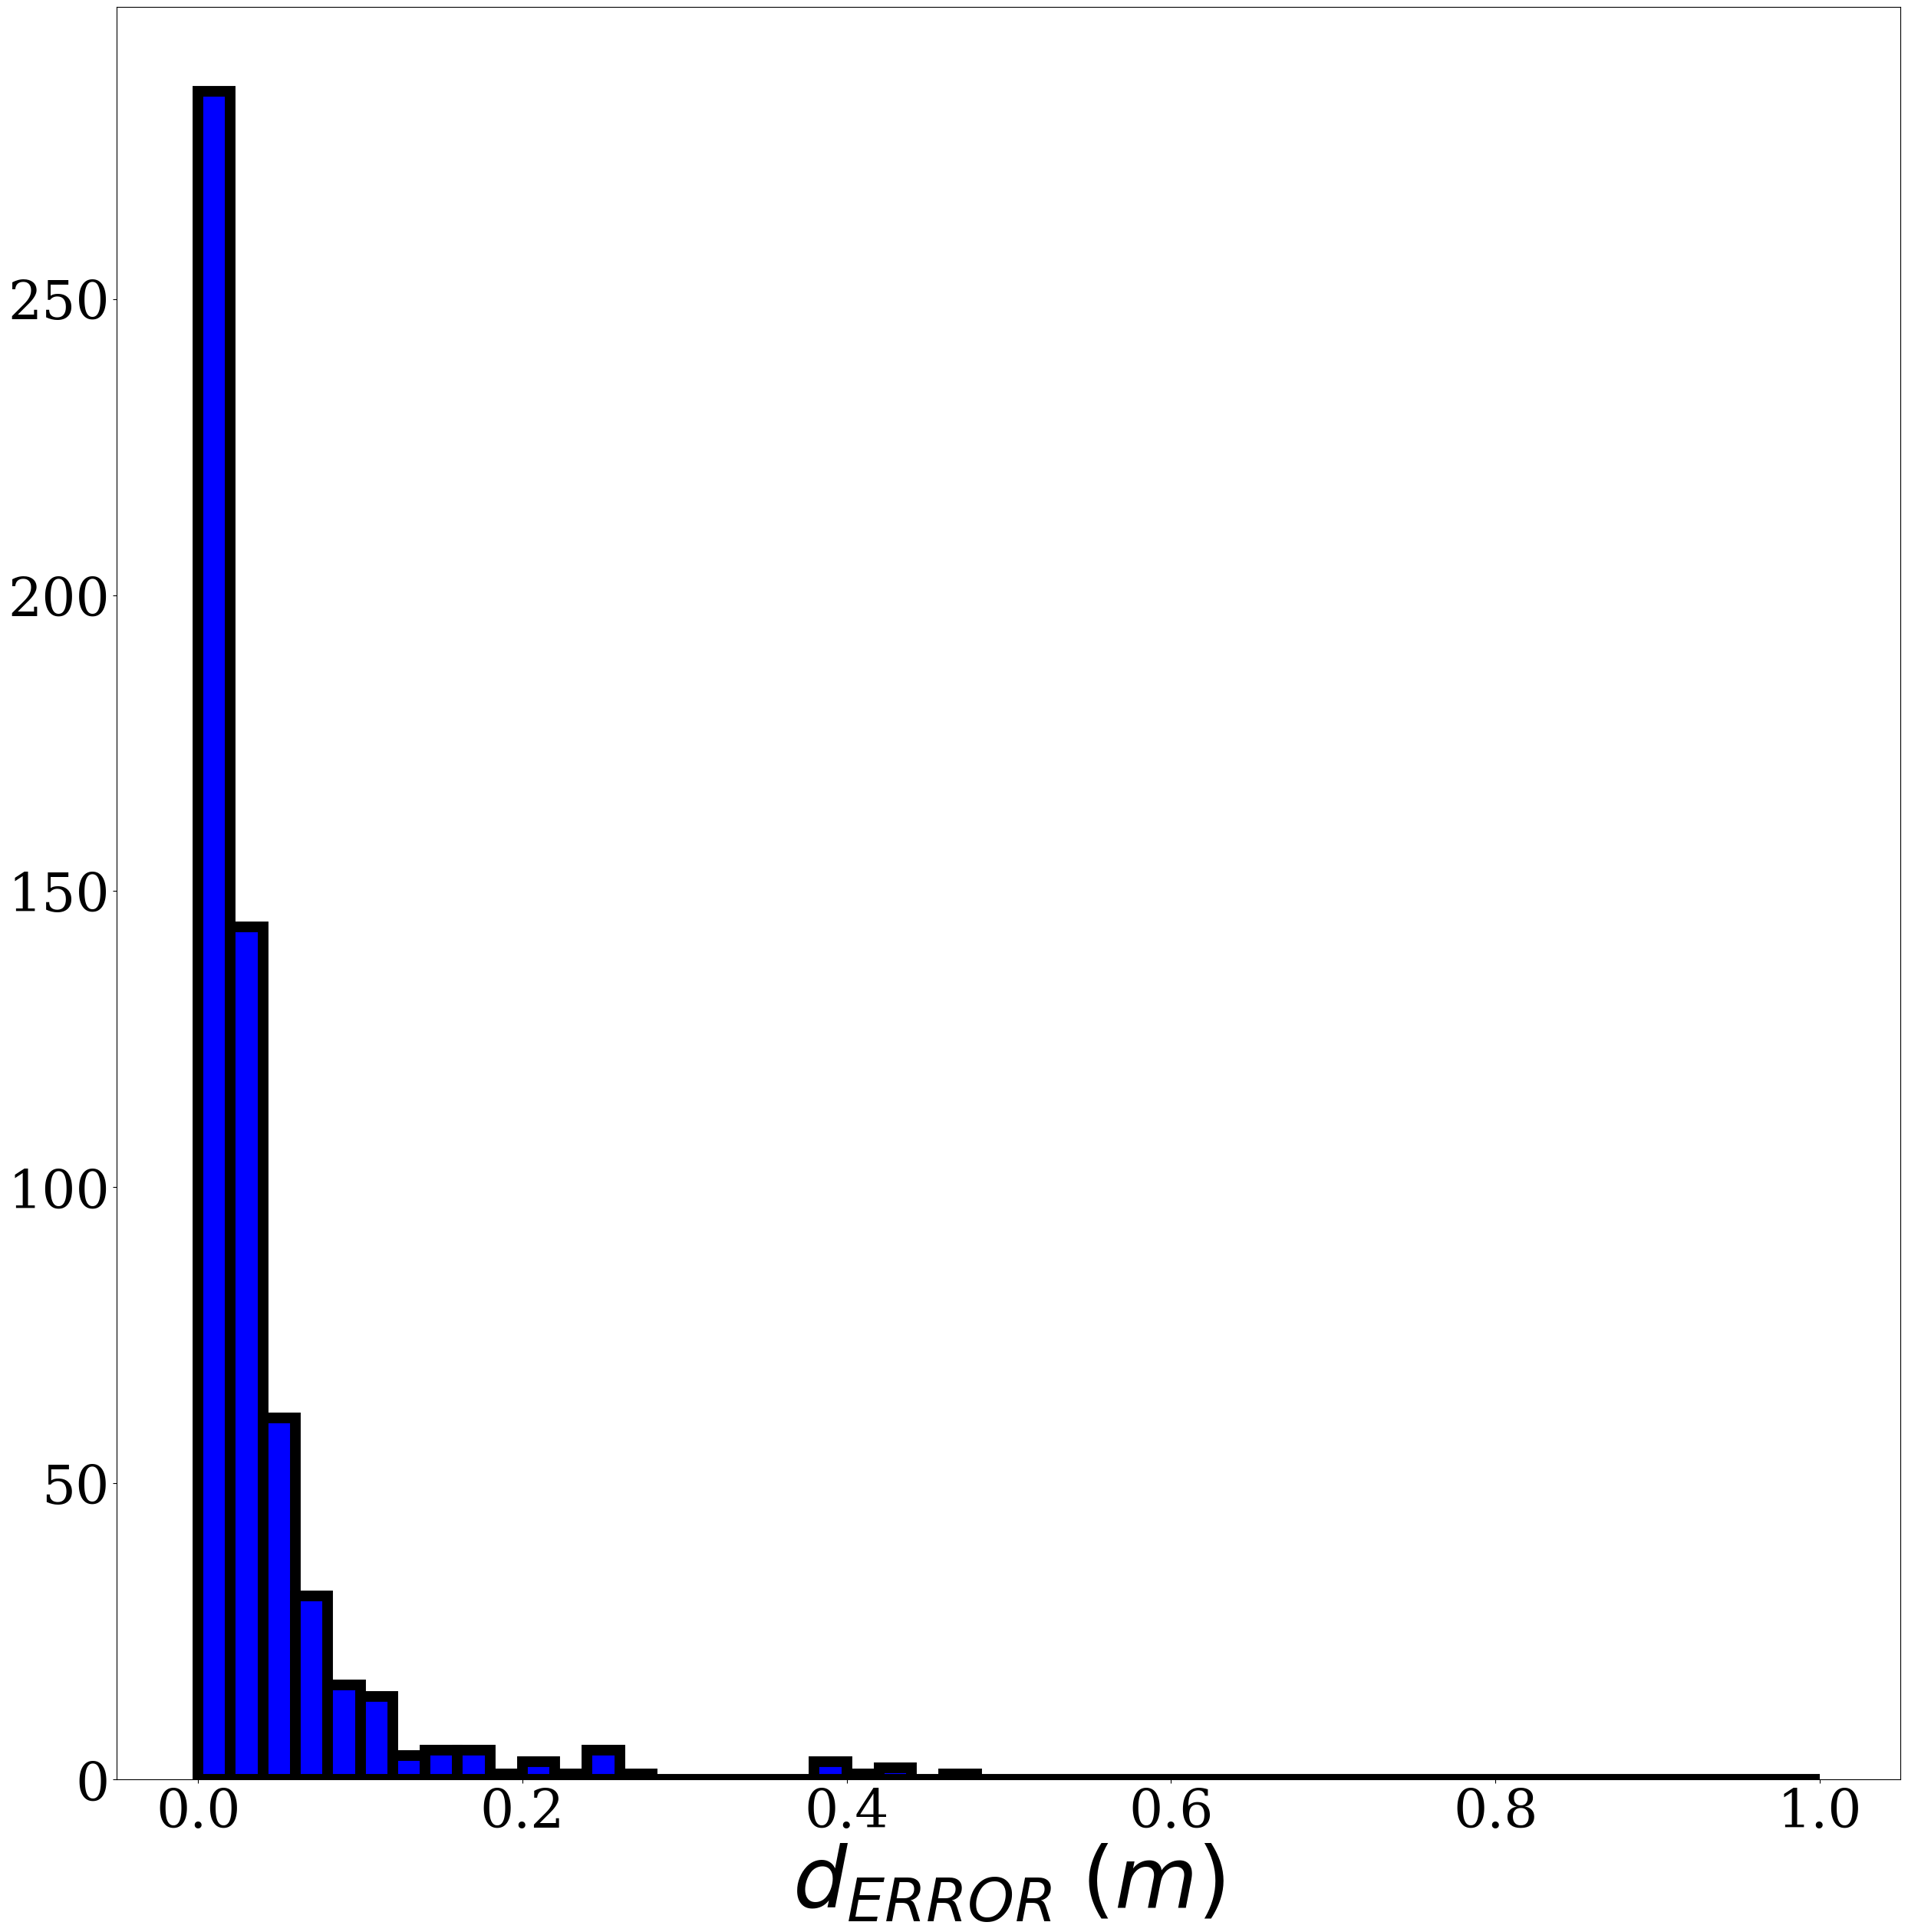

In [26]:

cols = dfs_epts[-1].columns
for i in range(len(dfs_dgps)):
    data_epts = dfs_epts[i].dropna(subset=['enu_x']).to_numpy().T
    data_dgps = dfs_true[i].to_numpy().T

    vErr = data_epts[list(cols).index('speed')] - data_dgps[list(cols).index('speed')]
    vRMSE = np.sqrt(np.mean(np.square(vErr)))

    dx = data_epts[list(cols).index('enu_x')] - data_dgps[list(cols).index('enu_x')]
    dy = data_epts[list(cols).index('enu_y')] - data_dgps[list(cols).index('enu_y')]
    pErr = np.sqrt(np.square(dx)+np.square(dy))
    pRMSE = np.sqrt(np.mean(np.square(pErr)))

    dx_epts = data_epts[list(cols).index('enu_x')][1:] - data_epts[list(cols).index('enu_x')][:-1]
    dy_epts = data_epts[list(cols).index('enu_y')][1:] - data_epts[list(cols).index('enu_y')][:-1]
    dist_epts = np.sqrt(np.square(dx_epts)+np.square(dy_epts))

    dx_dgps = data_dgps[list(cols).index('enu_x')][1:] - data_dgps[list(cols).index('enu_x')][:-1]
    dy_dgps = data_dgps[list(cols).index('enu_y')][1:] - data_dgps[list(cols).index('enu_y')][:-1]
    dist_dgps = np.sqrt(np.square(dx_dgps)+np.square(dy_dgps))
    dErr = dist_epts-dist_dgps
    dRMSE = np.sqrt(np.mean(np.square(dErr)))

    print(f"Meean errors | vErr: {np.mean(np.abs(vErr)):.5f}, pErr: {np.mean(np.abs(pErr)):.5f}, dErr: {np.mean(np.abs(dErr)):.5f}")
    print(f"RMSE values | vRMSE: {vRMSE:.5f}, pRMSE: {pRMSE:.5f}, dRMSE: {dRMSE:.5f}")
    plt.figure(2*i-1)
    plt.hist(vErr, bins=50, range=[-4,4], facecolor='blue', alpha=1.0, density=False, edgecolor='k', linewidth=10)
    plt.xlabel('$v_{ERROR}\;(m/s)$',fontsize=80)
    plt.xticks(fontsize =50)
    plt.yticks(fontsize =50)

    #plt.subplot(2,1,3)
    #plt.hist(pErr, bins=100)

    plt.figure(2*i, edgecolor='k')
    plt.hist(dErr, bins=50, range=[0,1], facecolor='blue', alpha=1.0, density=False, edgecolor='k', linewidth=10)
    plt.xlabel('$d_{ERROR}\;(m)$',fontsize=80)
    plt.xticks(fontsize =50)
    plt.yticks(fontsize =50)

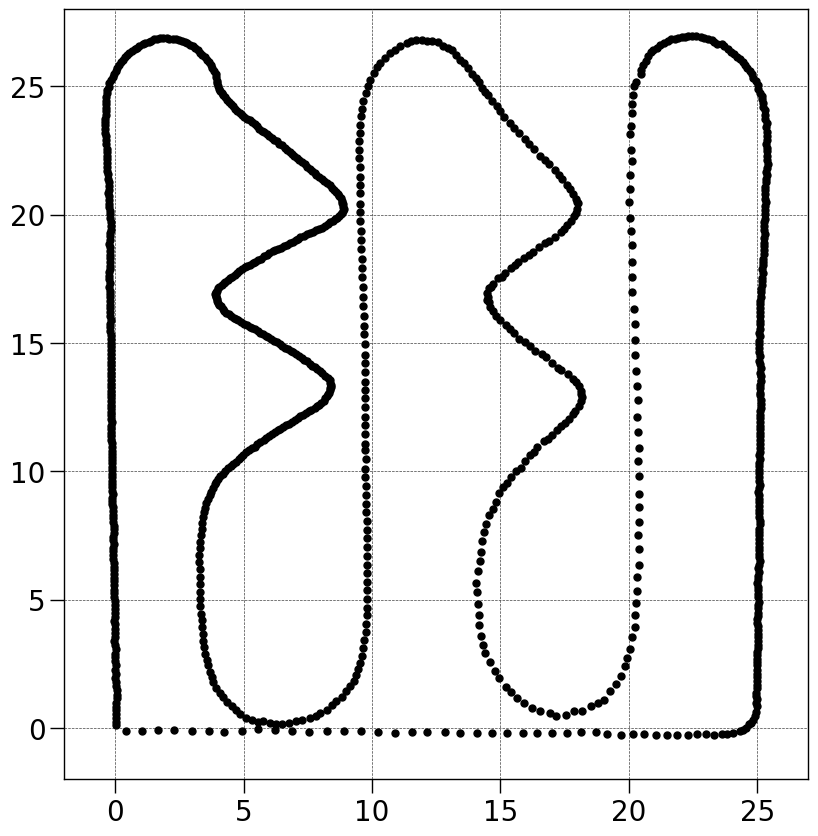

In [27]:

from matplotlib.ticker import AutoMinorLocator, MultipleLocator

def minor_tick(x, pos):
    if not x % 5.0:
        return ""
    return f"{x:.2f}"

def show_gps(df, idx_start=1, idx_end=None, enu_format=True, annotate=False):
    
    dx, dy, _ = geodetic_to_enu(lat0+0.0001,lon0+0.0001,0, lat0, lon0, h0)
    background_ratio = dy/dx

    time = df[['time']][idx_start:idx_end].to_numpy()
    lat  = df[['latitude']][idx_start:idx_end].to_numpy()
    lon  = df[['longitude']][idx_start:idx_end].to_numpy()
    enu_x = df[['enu_x']][idx_start:idx_end].to_numpy()
    enu_y = df[['enu_y']][idx_start:idx_end].to_numpy()

    pos_range = [129.3186, 129.3202, 36.0124, 36.0140] # POSTECH Field
    
    if(enu_format):
        lat = enu_y
        lon = enu_x
    else:
        #plt.axis(pos_range)
        img = plt.imread("background2.png")
        plt.imshow(img, extent=pos_range)

    if(annotate):
        for idx, xy in enumerate(zip(lon,lat)):
            if(idx % 10 == 0):
                plt.annotate('{}'.format(int(df.index[idx])), xy=xy, textcoords='data', fontsize=50)
        #       plt.annotate('{},{:.3f},{:.3f}'.format(idx, xy[0], xy[1]), xy=xy, textcoords='data')
    hfont = {'fontname':'Serif'}
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1,1,1,aspect=1)
    ax.plot(lon,lat,'ko', markersize=5, label='GPS Path')
    
    ax.grid(linestyle="--", linewidth=0.5, color='.25', zorder=-10)
    
    ax.set_xlim(-2, 27)
    ax.set_ylim(-2, 28)
    

    #ax.set_xlabel('X (m)', fontsize=30, labelpad=15, **hfont)
    #ax.set_ylabel('Y (m)', fontsize=30, labelpad=15, **hfont)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1)
        ax.spines[axis].set_color("black")
        ax.spines[axis].set_zorder(0)
    ax.xaxis.set_major_locator(MultipleLocator(5.00))
    #ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_major_locator(MultipleLocator(5.000))
    #ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    # FuncFormatter is created and used automatically
    
    ax.xaxis.set_minor_formatter(minor_tick)
    ax.tick_params(which='major', width=1.0, labelsize=20)
    ax.tick_params(which='major', length=10, labelsize=20)
    ax.tick_params(which='minor', width=1.0, labelsize=50)
    ax.tick_params(which='minor', length=10, labelsize=50)
    
    fig.savefig("figure.svg", format = 'svg', dpi=600)
    plt.show()
from matplotlib import rc, font_manager
rc('text', usetex=True)
rc('font',**{'family':'sans-serif','sans-serif':['Times New Roman']})
plt.style.use(['default']) 
show_gps(dfs_epts[0], enu_format=1)